In [92]:
# Module Import
import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix, ConfusionMatrixDisplay
import xgboost as xgb
import lightgbm as lgb
import tensorflow as tf
import json
from IPython.display import display
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Input, Dense, Dropout, BatchNormalization,
    GRU, LSTM, Bidirectional,
    Conv1D, MaxPooling1D, GlobalAveragePooling1D,
    LayerNormalization, MultiHeadAttention, Add
)
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tcn import TCN

In [ ]:
# 데이터 전처리
data = pd.read_csv("../frontend/public/sensor.csv")

all_zero_cols = data.columns[(data == 0).all()].tolist()
all_nan_cols = data.columns[data.isna().all()].tolist()
threshold = 1.2
low_std_cols = data.std(numeric_only=True).loc[lambda x: x < threshold].index.tolist()
useless_columns = list(set(all_zero_cols + all_nan_cols + low_std_cols))
data = data.drop(columns=useless_columns)

status_map = {'NORMAL': 0, 'RECOVERING': 1, 'BROKEN': 2}
data['machine_status_encoded'] = data['machine_status'].map(status_map)

data['timestamp'] = pd.to_datetime(data['timestamp'])
data.set_index('timestamp', inplace=True)
data = data.interpolate(method='time')

sensor_cols = [col for col in data.columns if col.startswith('sensor')]
scaler = StandardScaler()
data[sensor_cols] = scaler.fit_transform(data[sensor_cols])

data = data.drop(columns=['machine_status'])
data = data.sort_index()

C:\Users\LEETJ\AppData\Local\Temp\ipykernel_5824\2304049833.py:19: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data = data.interpolate(method='time')


Index(['Unnamed: 0', 'sensor_01', 'sensor_02', 'sensor_03', 'sensor_04',
       'sensor_05', 'sensor_06', 'sensor_07', 'sensor_08', 'sensor_09',
       'sensor_10', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14',
       'sensor_16', 'sensor_17', 'sensor_19', 'sensor_20', 'sensor_21',
       'sensor_22', 'sensor_23', 'sensor_24', 'sensor_25', 'sensor_26',
       'sensor_27', 'sensor_28', 'sensor_29', 'sensor_30', 'sensor_31',
       'sensor_32', 'sensor_33', 'sensor_34', 'sensor_35', 'sensor_36',
       'sensor_37', 'sensor_38', 'sensor_39', 'sensor_40', 'sensor_41',
       'sensor_42', 'sensor_43', 'sensor_44', 'sensor_45', 'sensor_46',
       'sensor_47', 'sensor_48', 'sensor_49', 'sensor_50', 'sensor_51',
       'machine_status_encoded'],
      dtype='object')

In [94]:
# 데이터 정보 조회
broken_row_numbers = np.where(data['machine_status_encoded'] == 2)[0].tolist()
broken_count = (data['machine_status_encoded'] == 2).sum()
print("BROKEN 인덱스:", broken_row_numbers)
print("전체 BROKEN 수:", broken_count)

total_rows = len(data)
train_ratio = 0.6
train_rows = int(total_rows * train_ratio)

print(f"총 행 수: {total_rows}")
print(f"Train 60% 행 수: {train_rows}")

BROKEN 인덱스: [17155, 24510, 69318, 77790, 128040, 141131, 166440]
전체 BROKEN 수: 7
총 행 수: 220320
Train 60% 행 수: 132192


In [95]:
# 데이터 분할
total_rows = len(data)
split_idx = int(total_rows * 0.6)
train_data = data.iloc[:split_idx]
test_data = data.iloc[split_idx:]

print(f"Train shape: {train_data.shape}")
print(f"Test shape: {test_data.shape}")

Train shape: (132192, 51)
Test shape: (88128, 51)


In [96]:
# 상태 예측 window
def create_windows_fast(data, window_size=60, step=1, label_col='machine_status_encoded'):
    sensor_cols = [col for col in data.columns if col.startswith('sensor')]
    sensor_data = data[sensor_cols].to_numpy(dtype=np.float32)
    label_data = data[label_col].to_numpy(dtype=np.int8)

    num_windows = (len(sensor_data) - window_size) // step
    X = np.empty((num_windows, window_size, len(sensor_cols)), dtype=np.float32)
    y = np.empty(num_windows, dtype=np.int8)

    for i in range(num_windows):
        idx = i * step
        X[i] = sensor_data[idx:idx + window_size]
        y[i] = label_data[idx + window_size]

    return X, y

X_train, y_train = create_windows_fast(train_data)
X_test, y_test = create_windows_fast(test_data)

print(X_train.shape)
print(y_train.shape)
print(np.unique(y_train, return_counts=True))

(132132, 60, 49)
(132132,)
(array([0, 1, 2], dtype=int8), array([122005,  10122,      5]))



Classification Report:
              precision    recall  f1-score   support

      NORMAL       1.00      1.00      1.00     83771
  RECOVERING       0.93      1.00      0.96      4295
      BROKEN       0.00      0.00      0.00         2

    accuracy                           1.00     88068
   macro avg       0.64      0.66      0.65     88068
weighted avg       1.00      1.00      1.00     88068



c:\Users\LEETJ\Desktop\SKKU-SFP\backend\tfenv\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\LEETJ\Desktop\SKKU-SFP\backend\tfenv\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\LEETJ\Desktop\SKKU-SFP\backend\tfenv\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

<Figure size 600x500 with 0 Axes>

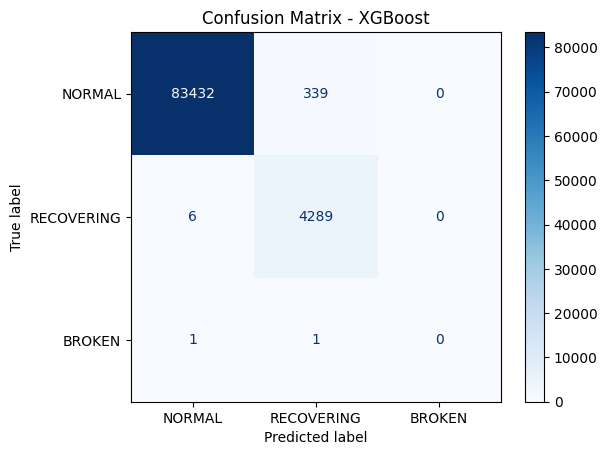

train 마지막 시점: 2018-07-01 19:11:00
test 첫 입력 시점 (window 기준): DatetimeIndex(['2018-07-01 19:12:00', '2018-07-01 19:13:00',
               '2018-07-01 19:14:00', '2018-07-01 19:15:00',
               '2018-07-01 19:16:00', '2018-07-01 19:17:00',
               '2018-07-01 19:18:00', '2018-07-01 19:19:00',
               '2018-07-01 19:20:00', '2018-07-01 19:21:00',
               '2018-07-01 19:22:00', '2018-07-01 19:23:00',
               '2018-07-01 19:24:00', '2018-07-01 19:25:00',
               '2018-07-01 19:26:00', '2018-07-01 19:27:00',
               '2018-07-01 19:28:00', '2018-07-01 19:29:00',
               '2018-07-01 19:30:00', '2018-07-01 19:31:00',
               '2018-07-01 19:32:00', '2018-07-01 19:33:00',
               '2018-07-01 19:34:00', '2018-07-01 19:35:00',
               '2018-07-01 19:36:00', '2018-07-01 19:37:00',
               '2018-07-01 19:38:00', '2018-07-01 19:39:00',
               '2018-07-01 19:40:00', '2018-07-01 19:41:00',
               '2018-07-0

In [97]:
# XGBoost
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    objective='multi:softmax',
    num_class=3,
    use_label_encoder=False,
    eval_metric='mlogloss',
    verbosity=0
)

# 학습
xgb_model.fit(X_train.reshape(X_train.shape[0], -1), y_train)

# 예측
y_pred = xgb_model.predict(X_test.reshape(X_test.shape[0], -1))
y_pred_xgb=y_pred

xgb_model.save_model("xgb_model.json")

# 결과
report_xgb = classification_report(
    y_test, y_pred, target_names=['NORMAL', 'RECOVERING', 'BROKEN'], output_dict=True
)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['NORMAL', 'RECOVERING', 'BROKEN']))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['NORMAL', 'RECOVERING', 'BROKEN'])

plt.figure(figsize=(6, 5))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - XGBoost")
plt.show()

print("train 마지막 시점:", train_data.index[-1])
print("test 첫 입력 시점 (window 기준):", test_data.index[:60])


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.603214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 733380
[LightGBM] [Info] Number of data points in the train set: 132132, number of used features: 2940
[LightGBM] [Info] Start training from score -0.079739
[LightGBM] [Info] Start training from score -2.569090
[LightGBM] [Info] Start training from score -10.182119
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\LEETJ\Desktop\SKKU-SFP\backend\tfenv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



Classification Report (LightGBM):
              precision    recall  f1-score   support

      NORMAL       1.00      0.98      0.99     83771
  RECOVERING       0.73      0.98      0.84      4295
      BROKEN       0.00      0.00      0.00         2

    accuracy                           0.98     88068
   macro avg       0.58      0.65      0.61     88068
weighted avg       0.99      0.98      0.98     88068



c:\Users\LEETJ\Desktop\SKKU-SFP\backend\tfenv\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\LEETJ\Desktop\SKKU-SFP\backend\tfenv\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\LEETJ\Desktop\SKKU-SFP\backend\tfenv\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

<Figure size 600x500 with 0 Axes>

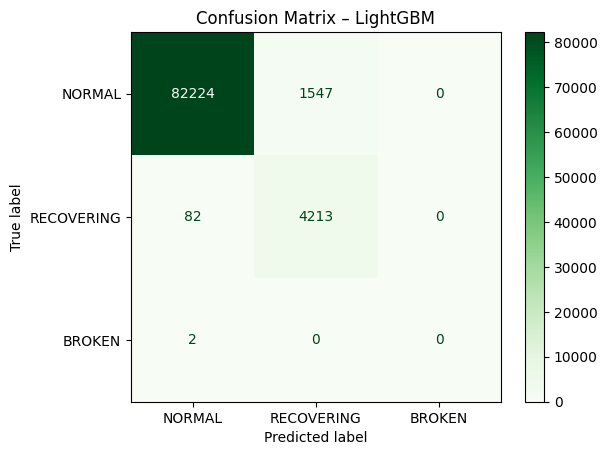

In [98]:
# LightGBM
lgbm_model = lgb.LGBMClassifier(
    n_estimators      = 200,
    max_depth        = -1,
    learning_rate    = 0.05,
    num_leaves       = 64,
    objective        = 'multiclass',
    class_weight     = None,
    subsample        = 0.8,
    colsample_bytree = 0.8,
    n_jobs           = -1,
    random_state     = 42
)

# 학습
lgbm_model.fit(
    X_train.reshape(X_train.shape[0], -1),
    y_train
)

# 예측
y_pred = lgbm_model.predict(
    X_test.reshape(X_test.shape[0], -1)
)
y_pred_lgbm=y_pred

lgbm_model.booster_.save_model("lgbm_model.txt")

# 결과
report_lgbm = classification_report(
    y_test, y_pred, target_names=['NORMAL', 'RECOVERING', 'BROKEN'], output_dict=True
)
print("\nClassification Report (LightGBM):")
print(classification_report(
    y_test, y_pred,
    target_names=['NORMAL', 'RECOVERING', 'BROKEN']
))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix = cm,
    display_labels   = ['NORMAL', 'RECOVERING', 'BROKEN']
)

plt.figure(figsize=(6, 5))
disp.plot(cmap='Greens', values_format='d')
plt.title("Confusion Matrix – LightGBM")
plt.show()

c:\Users\LEETJ\Desktop\SKKU-SFP\backend\tfenv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
826/826 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9866 - loss: 0.0448 - val_accuracy: 0.9029 - val_loss: 0.3703
Epoch 2/50
826/826 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9987 - loss: 0.0043 - val_accuracy: 0.8329 - val_loss: 1.0701
Epoch 3/50
826/826 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9992 - loss: 0.0025 - val_accuracy: 0.6387 - val_loss: 2.4579
Epoch 4/50
826/826 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9991 - loss: 0.0032 - val_accuracy: 0.9708 - val_loss: 0.2366
Epoch 5/50
826/826 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9991 - loss: 0.0027 - val_accuracy: 0.7989 - val_loss: 1.1116
Epoch 6/50
826/826 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9997 - loss: 0.0010 - val_accuracy: 0.7784 - val_loss: 1.1117
Epoch 7/50
826/826 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9995 - loss: 0.0018 - val_accuracy: 0.7291 - val_loss: 1.3503
Epoch 8/50
826/826 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9996 - loss: 0.0015 - val_accuracy: 0


Classification Report (1D-CNN):
              precision    recall  f1-score   support

      NORMAL       0.99      0.99      0.99     83771
  RECOVERING       0.82      0.73      0.77      4295
      BROKEN       0.00      0.00      0.00         2

    accuracy                           0.98     88068
   macro avg       0.60      0.57      0.59     88068
weighted avg       0.98      0.98      0.98     88068



c:\Users\LEETJ\Desktop\SKKU-SFP\backend\tfenv\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\LEETJ\Desktop\SKKU-SFP\backend\tfenv\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\LEETJ\Desktop\SKKU-SFP\backend\tfenv\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

<Figure size 600x500 with 0 Axes>

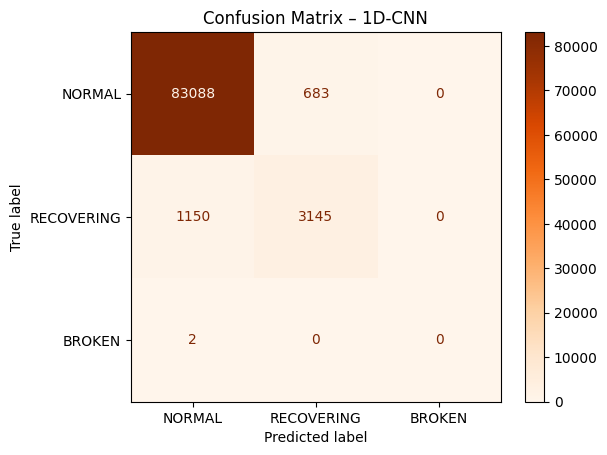

In [99]:
# 1D-CNN
y_train_cnn = tf.keras.utils.to_categorical(y_train, num_classes=3)
y_test_cnn = tf.keras.utils.to_categorical(y_test, num_classes=3)

cnn_model = Sequential([
    Conv1D(64, kernel_size=5, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    
    Conv1D(128, kernel_size=3, activation='relu'),
    BatchNormalization(),
    GlobalAveragePooling1D(),
    
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

cnn_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# 학습
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = cnn_model.fit(
    X_train, y_train_cnn,
    validation_split=0.2,
    epochs=50,
    batch_size=128,
    callbacks=[early_stop],
    verbose=1
)

# 예측
y_pred_proba = cnn_model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = np.argmax(y_test_cnn, axis=1)
y_pred_cnn=y_pred

cnn_model.save("cnn_model.h5")

# 결과
report_cnn = classification_report(
    y_true, y_pred, target_names=['NORMAL', 'RECOVERING', 'BROKEN'], output_dict=True
)
print("\nClassification Report (1D-CNN):")
print(classification_report(y_true, y_pred, target_names=['NORMAL', 'RECOVERING', 'BROKEN']))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['NORMAL', 'RECOVERING', 'BROKEN'])

plt.figure(figsize=(6, 5))
disp.plot(cmap='Oranges', values_format='d')
plt.title("Confusion Matrix – 1D-CNN")
plt.show()


c:\Users\LEETJ\Desktop\SKKU-SFP\backend\tfenv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
826/826 ━━━━━━━━━━━━━━━━━━━━ 43s 51ms/step - accuracy: 0.9763 - loss: 0.0662 - val_accuracy: 0.9241 - val_loss: 0.1785
Epoch 2/50
826/826 ━━━━━━━━━━━━━━━━━━━━ 41s 49ms/step - accuracy: 0.9990 - loss: 0.0030 - val_accuracy: 0.9510 - val_loss: 0.1801
Epoch 3/50
826/826 ━━━━━━━━━━━━━━━━━━━━ 41s 49ms/step - accuracy: 0.9991 - loss: 0.0029 - val_accuracy: 0.8829 - val_loss: 0.3683
Epoch 4/50
826/826 ━━━━━━━━━━━━━━━━━━━━ 41s 50ms/step - accuracy: 0.9991 - loss: 0.0027 - val_accuracy: 0.8548 - val_loss: 0.5528
Epoch 5/50
826/826 ━━━━━━━━━━━━━━━━━━━━ 41s 50ms/step - accuracy: 0.9995 - loss: 0.0017 - val_accuracy: 0.8279 - val_loss: 0.8414
Epoch 6/50
826/826 ━━━━━━━━━━━━━━━━━━━━ 42s 50ms/step - accuracy: 0.9996 - loss: 0.0014 - val_accuracy: 0.8604 - val_loss: 0.8437
2753/2753 ━━━━━━━━━━━━━━━━━━━━ 25s 9ms/step



Classification Report (LSTM):
              precision    recall  f1-score   support

      NORMAL       0.99      0.98      0.99     83771
  RECOVERING       0.71      0.76      0.73      4295
      BROKEN       0.00      0.00      0.00         2

    accuracy                           0.97     88068
   macro avg       0.56      0.58      0.57     88068
weighted avg       0.97      0.97      0.97     88068



c:\Users\LEETJ\Desktop\SKKU-SFP\backend\tfenv\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\LEETJ\Desktop\SKKU-SFP\backend\tfenv\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\LEETJ\Desktop\SKKU-SFP\backend\tfenv\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

<Figure size 600x500 with 0 Axes>

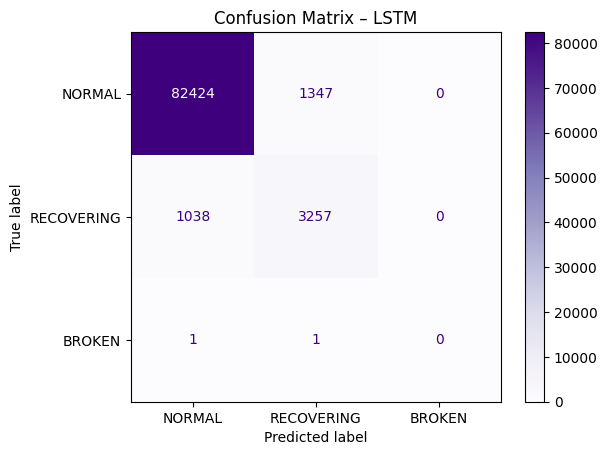

In [100]:
# LSTM
y_train_lstm = tf.keras.utils.to_categorical(y_train, num_classes=3)
y_test_lstm = tf.keras.utils.to_categorical(y_test, num_classes=3)

lstm_model = Sequential([
    LSTM(128, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])

lstm_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# 학습
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = lstm_model.fit(
    X_train, y_train_lstm,
    validation_split=0.2,
    epochs=50,
    batch_size=128,
    callbacks=[early_stop],
    verbose=1
)

# 예측
y_pred_proba = lstm_model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = np.argmax(y_test_lstm, axis=1)
y_pred_lstm=y_pred

lstm_model.save("lstm_model.h5")

# 결과
report_lstm = classification_report(
    y_true, y_pred, target_names=['NORMAL', 'RECOVERING', 'BROKEN'], output_dict=True
)
print("\nClassification Report (LSTM):")
print(classification_report(y_true, y_pred, target_names=['NORMAL', 'RECOVERING', 'BROKEN']))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['NORMAL', 'RECOVERING', 'BROKEN'])

plt.figure(figsize=(6, 5))
disp.plot(cmap='Purples', values_format='d')
plt.title("Confusion Matrix – LSTM")
plt.show()

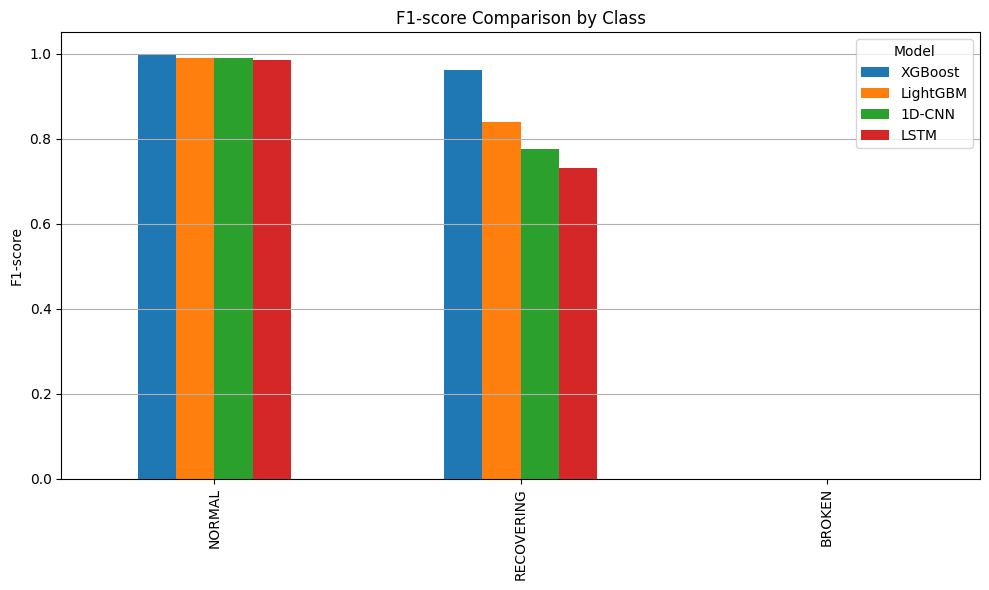

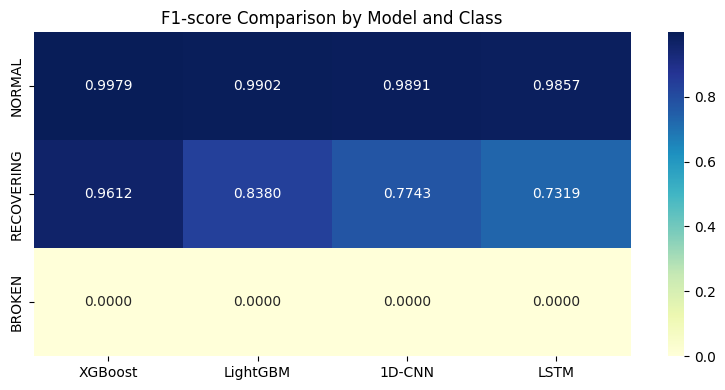

In [101]:
# 전체 예측 F1-score 비교
f1_scores = pd.DataFrame({
    'XGBoost':    [report_xgb[c]['f1-score'] for c in ['NORMAL', 'RECOVERING', 'BROKEN']],
    'LightGBM':   [report_lgbm[c]['f1-score'] for c in ['NORMAL', 'RECOVERING', 'BROKEN']],
    '1D-CNN':     [report_cnn[c]['f1-score'] for c in ['NORMAL', 'RECOVERING', 'BROKEN']],
    'LSTM':       [report_lstm[c]['f1-score'] for c in ['NORMAL', 'RECOVERING', 'BROKEN']],
}, index=['NORMAL', 'RECOVERING', 'BROKEN'])

# 1. 그래프
f1_scores.plot(kind='bar', figsize=(10, 6))
plt.title("F1-score Comparison by Class")
plt.ylabel("F1-score")
plt.ylim(0, 1.05)
plt.grid(axis='y')
plt.legend(title="Model")
plt.tight_layout()
plt.show()

# 2. 히트맵
plt.figure(figsize=(8, 4))
sns.heatmap(f1_scores, annot=True, fmt=".4f", cmap="YlGnBu")
plt.title("F1-score Comparison by Model and Class")
plt.tight_layout()
plt.show()

f1_scores_dict = {
    "index": f1_scores.index.tolist(),
    "columns": f1_scores.columns.tolist(),
    "data": f1_scores.values.tolist()
}

with open("f1_scores.json", "w") as f:
    json.dump(f1_scores_dict, f, indent=2)

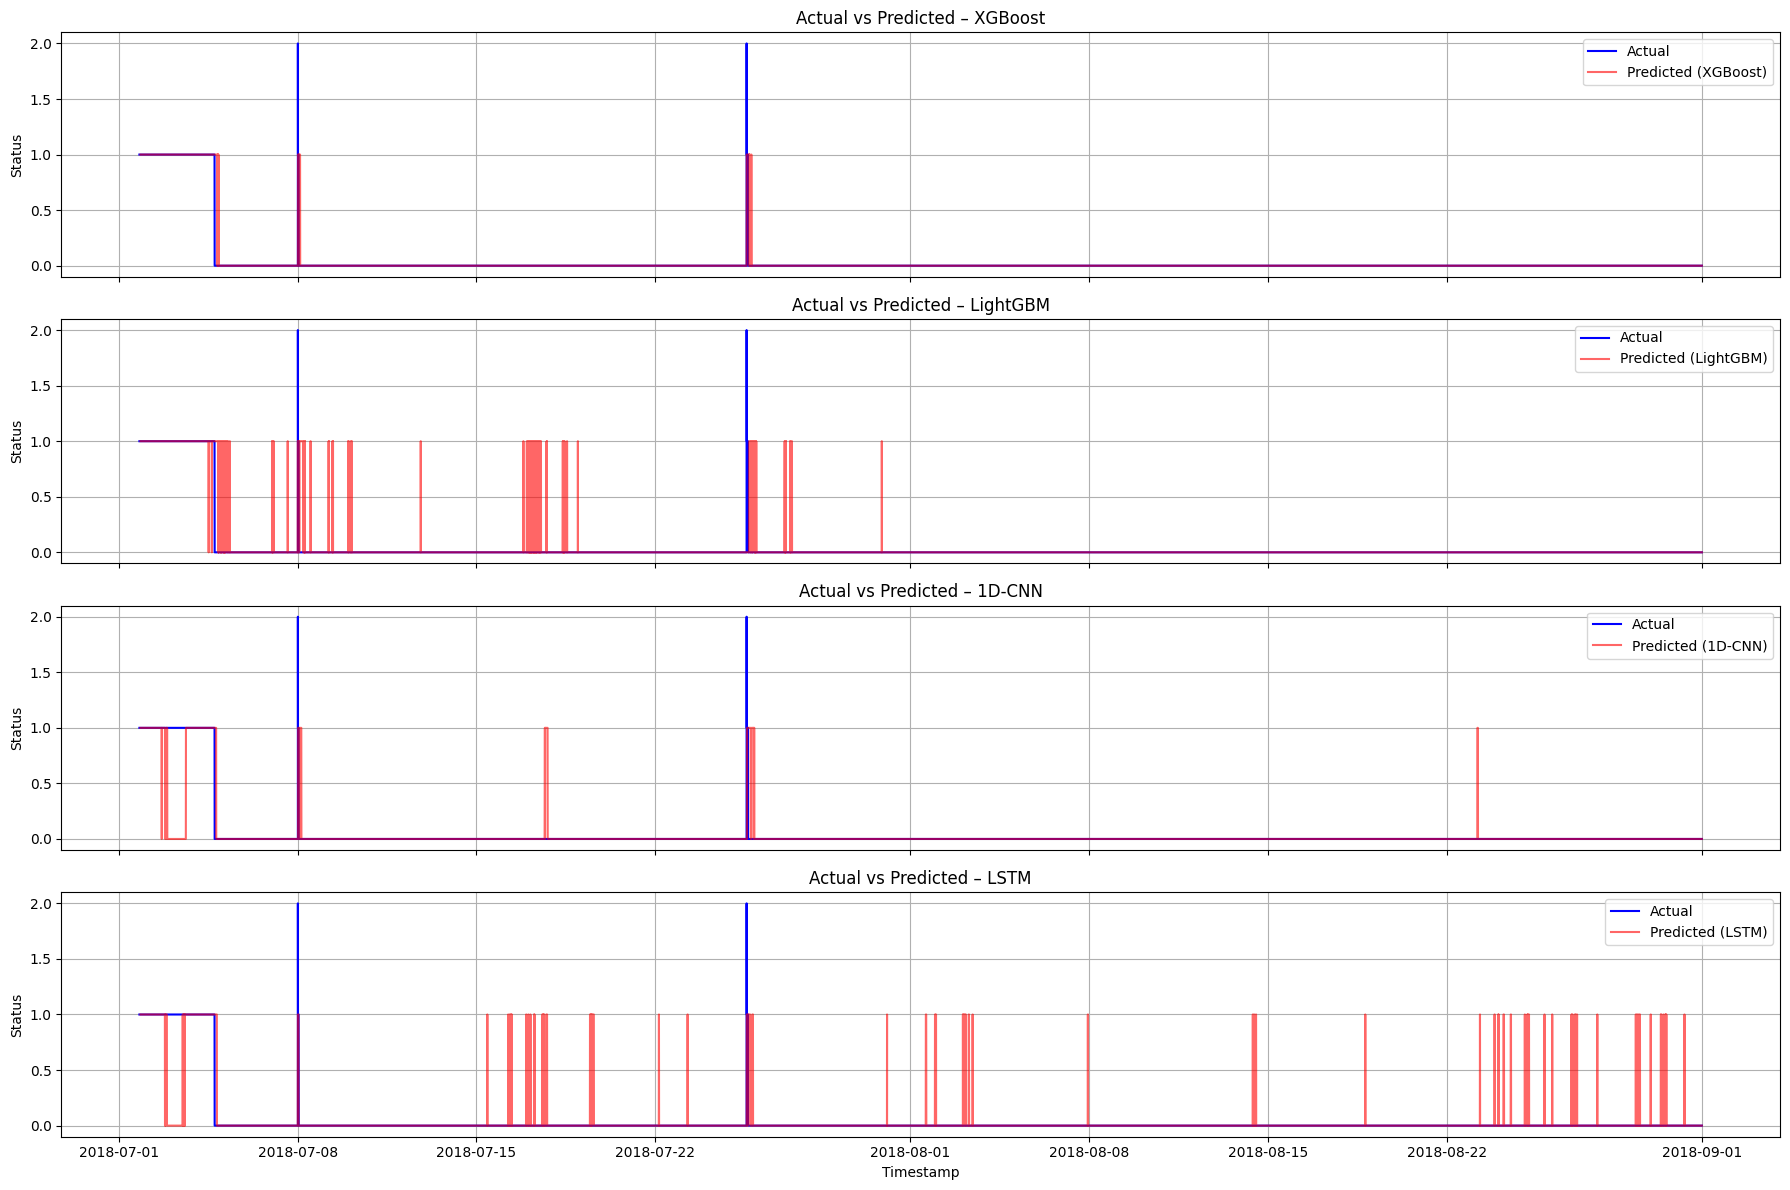

In [102]:
# 전체 예측 결과 차트로 비교
# 1. 테스트 데이터 기준 timestamp와 실제 레이블
test_timestamps = test_data.index.to_series().reset_index(drop=True)
y_true = test_data['machine_status_encoded'].values

# 2. 각 예측 결과에 맞춰 padding 처리
def pad_prediction(y_pred, target_len):
    pad_len = target_len - len(y_pred)
    return np.concatenate([np.full(pad_len, np.nan), y_pred])

y_pred_xgb   = pad_prediction(y_pred_xgb,   len(test_timestamps))
y_pred_lgbm  = pad_prediction(y_pred_lgbm,  len(test_timestamps))
y_pred_cnn   = pad_prediction(y_pred_cnn,   len(test_timestamps))
y_pred_lstm  = pad_prediction(y_pred_lstm,  len(test_timestamps))

# 3. 시각화 (4줄 subplot)
fig, axes = plt.subplots(4, 1, figsize=(18, 12), sharex=True)

model_names = ['XGBoost', 'LightGBM', '1D-CNN', 'LSTM']
predictions = [y_pred_xgb, y_pred_lgbm, y_pred_cnn, y_pred_lstm]

result_df = pd.DataFrame({
    "timestamp": test_timestamps.astype(str),
    "actual": y_true.tolist(),
    "XGBoost": y_pred_xgb.tolist(),
    "LightGBM": y_pred_lgbm.tolist(),
    "1D-CNN": y_pred_cnn.tolist(),
    "LSTM": y_pred_lstm.tolist()
})
result_df.to_json("prediction_results.json", orient="records", indent=2)

for i, ax in enumerate(axes):
    ax.plot(test_timestamps, y_true, color='blue', label='Actual')
    ax.plot(test_timestamps, predictions[i], color='red', alpha=0.6, label=f'Predicted ({model_names[i]})')
    ax.set_ylabel("Status")
    ax.set_title(f"Actual vs Predicted – {model_names[i]}")
    ax.grid(True)
    ax.legend(loc='upper right')

plt.xlabel("Timestamp")
plt.tight_layout()
plt.show()

In [103]:
import json
import pandas as pd

train_timestamps = train_data.index.to_series().reset_index(drop=True)
train_labels = train_data["machine_status_encoded"].values

y_pred_xgb = predictions[0]

train_rec_times = train_timestamps[(train_labels == 1)].astype(str).tolist()
test_rec_times = test_timestamps[(y_pred_xgb == 1)].astype(str).tolist()

all_rec_times = sorted(set(train_rec_times + test_rec_times))

recovering_regions = [{
    "recovering_timestamps": all_rec_times
}]

with open("recovering_regions.json", "w", encoding="utf-8") as f:
    json.dump(recovering_regions, f, indent=2, ensure_ascii=False)


In [104]:
# 트렌드 예측 window
def create_sensor_trend_windows(data, sensor_cols, window_size=60, step=1):
    sensor_data = data[sensor_cols].to_numpy(dtype=np.float32)
    num_windows = (len(sensor_data) - window_size) // step

    X = np.empty((num_windows, window_size, len(sensor_cols)), dtype=np.float32)
    y = np.empty((num_windows, len(sensor_cols)), dtype=np.float32)

    for i in range(num_windows):
        idx = i * step
        X[i] = sensor_data[idx:idx + window_size]
        y[i] = sensor_data[idx + window_size]
    return X, y

X_train, y_train = create_sensor_trend_windows(train_data, sensor_cols)
X_test, y_test = create_sensor_trend_windows(test_data, sensor_cols)

print(X_train.shape)
print(y_train.shape)
print(np.unique(y_train, return_counts=True))

(132132, 60, 49)
(132132, 49)
(array([-7.619729 , -4.9521065, -4.9496913, ..., 33.584682 , 33.930584 ,
       34.05411  ], dtype=float32), array([   1, 3527,  103, ...,    1,    1,    1]))


In [105]:
# 모델 약식 평가 (6개 모델: GRU, LSTM, BiLSTM, TCN, 1D-CNN, Transformer)
# 데이터 축소 (10% 샘플링)
subset_size = int(len(X_train) * 0.1)
X_train_small = X_train[:subset_size]
y_train_small = y_train[:subset_size]

early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

def evaluate_model(name, y_true, y_pred):
    mse_list = [mean_squared_error(y_true[:, i], y_pred[:, i]) for i in range(len(sensor_cols))]
    return pd.DataFrame({'Sensor': sensor_cols, f'{name}_MSE': mse_list})

# 1. GRU
gru_model = Sequential([
    GRU(64, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(len(sensor_cols))
])
gru_model.compile(optimizer='adam', loss='mse')
gru_model.fit(X_train_small, y_train_small, validation_split=0.2, epochs=5, batch_size=64, verbose=0)
gru_y_pred = gru_model.predict(X_test)
df_gru = evaluate_model('GRU', y_test, gru_y_pred)

# 2. LSTM
lstm_model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(len(sensor_cols))
])
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train_small, y_train_small, validation_split=0.2, epochs=5, batch_size=64, verbose=0)
lstm_y_pred = lstm_model.predict(X_test)
df_lstm = evaluate_model('LSTM', y_test, lstm_y_pred)

# 3. BiLSTM
bilstm_model = Sequential([
    Bidirectional(LSTM(64), input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(len(sensor_cols))
])
bilstm_model.compile(optimizer='adam', loss='mse')
bilstm_model.fit(X_train_small, y_train_small, validation_split=0.2, epochs=5, batch_size=64, verbose=0)
bilstm_y_pred = bilstm_model.predict(X_test)
df_bilstm = evaluate_model('BiLSTM', y_test, bilstm_y_pred)

# 4. TCN
tcn_model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    TCN(nb_filters=32, kernel_size=3, dilations=[1, 2, 4], dropout_rate=0.1),
    Dense(len(sensor_cols))
])
tcn_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
tcn_model.fit(X_train_small, y_train_small, validation_split=0.2, epochs=5, batch_size=64, verbose=0, callbacks=[early_stop])
tcn_y_pred = tcn_model.predict(X_test)
df_tcn = evaluate_model('TCN', y_test, tcn_y_pred)

# 5. 1D-CNN
cnn_model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    GlobalAveragePooling1D(),
    Dense(len(sensor_cols))
])
cnn_model.compile(optimizer='adam', loss='mse')
cnn_model.fit(X_train_small, y_train_small, validation_split=0.2, epochs=5, batch_size=64, verbose=0)
cnn_y_pred = cnn_model.predict(X_test)
df_cnn = evaluate_model('1D_CNN', y_test, cnn_y_pred)

# 6. Transformer
def transformer_block(inputs, num_heads=2, ff_dim=64, dropout=0.1):
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=inputs.shape[-1])(inputs, inputs)
    attn_output = Dropout(dropout)(attn_output)
    out1 = LayerNormalization(epsilon=1e-6)(inputs + attn_output)

    ff_output = Dense(ff_dim, activation='relu')(out1)
    ff_output = Dense(inputs.shape[-1])(ff_output)
    ff_output = Dropout(dropout)(ff_output)
    return LayerNormalization(epsilon=1e-6)(out1 + ff_output)

input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))
x = transformer_block(input_layer)
x = GlobalAveragePooling1D()(x)
output_layer = Dense(len(sensor_cols))(x)

transformer_model = Model(inputs=input_layer, outputs=output_layer)
transformer_model.compile(optimizer='adam', loss='mse')
transformer_model.fit(X_train_small, y_train_small, validation_split=0.2, epochs=5, batch_size=64, verbose=0)
transformer_y_pred = transformer_model.predict(X_test)
df_trans = evaluate_model('Transformer', y_test, transformer_y_pred)

mse_all = df_gru.merge(df_lstm, on='Sensor')\
                .merge(df_bilstm, on='Sensor')\
                .merge(df_tcn, on='Sensor')\
                .merge(df_cnn, on='Sensor')\
                .merge(df_trans, on='Sensor')

print(mse_all.sort_values("GRU_MSE"))

model_names = ['GRU', 'LSTM', 'BiLSTM', 'TCN', '1D_CNN', 'Transformer']

mean_mses = {
    model: mse_all[f'{model}_MSE'].mean()
    for model in model_names
}
sensor_mses = mse_all.to_dict(orient='records')

combined = {
    "summary": mean_mses,
    "details": sensor_mses
}

with open("combined_mse.json", "w") as f:
    json.dump(combined, f, indent=2)

c:\Users\LEETJ\Desktop\SKKU-SFP\backend\tfenv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2753/2753 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step


c:\Users\LEETJ\Desktop\SKKU-SFP\backend\tfenv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2753/2753 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step


c:\Users\LEETJ\Desktop\SKKU-SFP\backend\tfenv\lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2753/2753 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step
2753/2753 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step


c:\Users\LEETJ\Desktop\SKKU-SFP\backend\tfenv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2753/2753 ━━━━━━━━━━━━━━━━━━━━ 2s 734us/step
2753/2753 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step
       Sensor   GRU_MSE  LSTM_MSE  BiLSTM_MSE   TCN_MSE  1D_CNN_MSE  \
16  sensor_19  0.053667  0.167504    0.188056  0.070226    0.104748   
12  sensor_13  0.060111  0.368117    0.243520  0.632107    1.552884   
33  sensor_36  0.075096  0.642001    0.106850  1.555028    1.279850   
21  sensor_24  0.085859  0.118801    0.161130  0.204430    0.142965   
25  sensor_28  0.092947  0.153717    0.159978  0.378911    0.131082   
14  sensor_16  0.096137  0.042697    0.166002  0.119399    0.322687   
30  sensor_33  0.111427  0.069903    0.083960  0.245799    0.372904   
28  sensor_31  0.114380  0.245671    0.107483  0.348418    0.459667   
26  sensor_29  0.115612  0.154409    0.226566  1.271820    0.310415   
18  sensor_21  0.129276  0.054793    0.160893  0.262629    0.095155   
48  sensor_51  0.146346  0.171947    0.193714  0.476091    0.472186   
17  sensor_20  0.153265  0.089979    0.097794  0.139398    

C:\Users\LEETJ\AppData\Local\Temp\ipykernel_5824\2467637319.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=summary_df, x="Avg_MSE", y="Model", palette="viridis")
C:\Users\LEETJ\AppData\Local\Temp\ipykernel_5824\2467637319.py:15: UserWarning: Glyph 47784 (\N{HANGUL SYLLABLE MO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\LEETJ\AppData\Local\Temp\ipykernel_5824\2467637319.py:15: UserWarning: Glyph 45944 (\N{HANGUL SYLLABLE DEL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\LEETJ\AppData\Local\Temp\ipykernel_5824\2467637319.py:15: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\LEETJ\AppData\Local\Temp\ipykernel_5824\2467637319.py:15: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from font(s) DejaVu Sans.
 

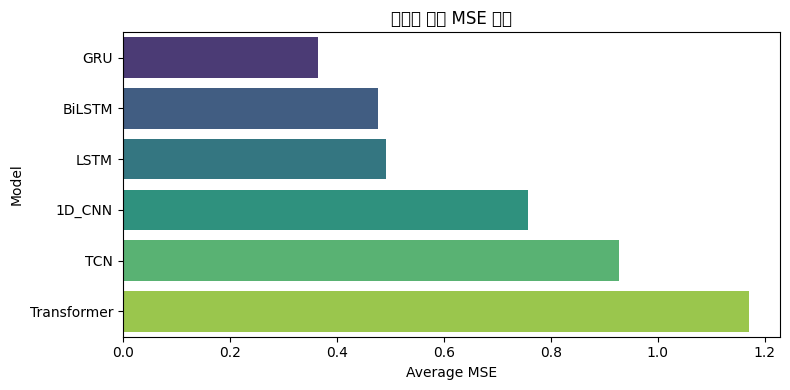


[모델별 센서 MSE 요약]
      Model Min_Sensor  Min_MSE Max_Sensor  Max_MSE
     1D_CNN  sensor_17 0.074425  sensor_50 2.020348
     BiLSTM  sensor_25 0.055403  sensor_50 1.567992
        GRU  sensor_19 0.053667  sensor_50 1.626665
       LSTM  sensor_16 0.042697  sensor_50 1.641578
        TCN  sensor_17 0.049180  sensor_50 4.274837
Transformer  sensor_16 0.071609  sensor_46 5.271750


In [106]:
# 모델 약식 평가 시각화 (6개 모델: GRU, LSTM, BiLSTM, TCN, 1D-CNN, Transformer)

with open("combined_mse.json", "r") as f:
    data = json.load(f)

summary_df = pd.DataFrame(data["summary"].items(), columns=["Model", "Avg_MSE"]).sort_values("Avg_MSE")

details_df = pd.DataFrame(data["details"])

plt.figure(figsize=(8, 4))
sns.barplot(data=summary_df, x="Avg_MSE", y="Model", palette="viridis")
plt.title("모델별 평균 MSE 비교")
plt.xlabel("Average MSE")
plt.ylabel("Model")
plt.tight_layout()
plt.show()

model_names = [col.replace("_MSE", "") for col in details_df.columns if col.endswith("_MSE")]

extreme_rows = []
for model in model_names:
    col = f"{model}_MSE"
    min_row = details_df.loc[details_df[col].idxmin()]
    max_row = details_df.loc[details_df[col].idxmax()]
    extreme_rows.append({
        "Model": model,
        "Min_Sensor": min_row["Sensor"],
        "Min_MSE": min_row[col],
        "Max_Sensor": max_row["Sensor"],
        "Max_MSE": max_row[col]
    })

extreme_df = pd.DataFrame(extreme_rows).sort_values("Model")

print("\n[모델별 센서 MSE 요약]")
print(extreme_df.to_string(index=False))


In [107]:
# GRU, BiLSTM, LSTM 학습
gru_trend_model = Sequential([
    GRU(128, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(len(sensor_cols))
])
gru_trend_model.compile(optimizer='adam', loss='mse')
gru_trend_model.fit(X_train, y_train, validation_split=0.2, epochs=30, batch_size=128, verbose=1)

gru_trend_model.save("gru_trend_model.h5")

# BiLSTM
bilstm_trend_model = Sequential([
    Bidirectional(LSTM(128), input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(len(sensor_cols))
])
bilstm_trend_model.compile(optimizer='adam', loss='mse')
bilstm_trend_model.fit(X_train, y_train, validation_split=0.2, epochs=30, batch_size=128, verbose=1)

bilstm_trend_model.save("bilstm_trend_model.h5")

# LSTM
lstm_trend_model = Sequential([
    LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(len(sensor_cols))
])
lstm_trend_model.compile(optimizer='adam', loss='mse')
lstm_trend_model.fit(X_train, y_train, validation_split=0.2, epochs=30, batch_size=128, verbose=1)

lstm_trend_model.save("lstm_trend_model.h5")

c:\Users\LEETJ\Desktop\SKKU-SFP\backend\tfenv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
826/826 ━━━━━━━━━━━━━━━━━━━━ 63s 76ms/step - loss: 0.1681 - val_loss: 0.1480
Epoch 2/30
826/826 ━━━━━━━━━━━━━━━━━━━━ 60s 73ms/step - loss: 0.0114 - val_loss: 0.0832
Epoch 3/30
826/826 ━━━━━━━━━━━━━━━━━━━━ 60s 73ms/step - loss: 0.0075 - val_loss: 0.0606
Epoch 4/30
826/826 ━━━━━━━━━━━━━━━━━━━━ 60s 73ms/step - loss: 0.0062 - val_loss: 0.0478
Epoch 5/30
826/826 ━━━━━━━━━━━━━━━━━━━━ 61s 73ms/step - loss: 0.0061 - val_loss: 0.0425
Epoch 6/30
826/826 ━━━━━━━━━━━━━━━━━━━━ 61s 73ms/step - loss: 0.0057 - val_loss: 0.0381
Epoch 7/30
826/826 ━━━━━━━━━━━━━━━━━━━━ 60s 72ms/step - loss: 0.0058 - val_loss: 0.0360
Epoch 8/30
826/826 ━━━━━━━━━━━━━━━━━━━━ 61s 73ms/step - loss: 0.0057 - val_loss: 0.0354
Epoch 9/30
826/826 ━━━━━━━━━━━━━━━━━━━━ 59s 72ms/step - loss: 0.0055 - val_loss: 0.0355
Epoch 10/30
826/826 ━━━━━━━━━━━━━━━━━━━━ 60s 72ms/step - loss: 0.0056 - val_loss: 0.0333
Epoch 11/30
826/826 ━━━━━━━━━━━━━━━━━━━━ 59s 71ms/step - loss: 0.0053 - val_loss: 0.0331
Epoch 12/30
826/826 ━━━━━━━━━━

c:\Users\LEETJ\Desktop\SKKU-SFP\backend\tfenv\lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
826/826 ━━━━━━━━━━━━━━━━━━━━ 71s 84ms/step - loss: 0.1557 - val_loss: 0.3428
Epoch 2/30
826/826 ━━━━━━━━━━━━━━━━━━━━ 66s 80ms/step - loss: 0.0119 - val_loss: 0.2727
Epoch 3/30
826/826 ━━━━━━━━━━━━━━━━━━━━ 66s 79ms/step - loss: 0.0080 - val_loss: 0.3114
Epoch 4/30
826/826 ━━━━━━━━━━━━━━━━━━━━ 65s 79ms/step - loss: 0.0067 - val_loss: 0.3051
Epoch 5/30
826/826 ━━━━━━━━━━━━━━━━━━━━ 67s 81ms/step - loss: 0.0066 - val_loss: 0.2390
Epoch 6/30
826/826 ━━━━━━━━━━━━━━━━━━━━ 66s 80ms/step - loss: 0.0062 - val_loss: 0.3583
Epoch 7/30
826/826 ━━━━━━━━━━━━━━━━━━━━ 66s 80ms/step - loss: 0.0059 - val_loss: 0.2324
Epoch 8/30
826/826 ━━━━━━━━━━━━━━━━━━━━ 65s 79ms/step - loss: 0.0056 - val_loss: 0.2466
Epoch 9/30
826/826 ━━━━━━━━━━━━━━━━━━━━ 66s 80ms/step - loss: 0.0056 - val_loss: 0.2560
Epoch 10/30
826/826 ━━━━━━━━━━━━━━━━━━━━ 66s 80ms/step - loss: 0.0056 - val_loss: 0.2857
Epoch 11/30
826/826 ━━━━━━━━━━━━━━━━━━━━ 67s 81ms/step - loss: 0.0054 - val_loss: 0.2339
Epoch 12/30
826/826 ━━━━━━━━━━

Epoch 1/30
826/826 ━━━━━━━━━━━━━━━━━━━━ 47s 56ms/step - loss: 0.1821 - val_loss: 0.2726
Epoch 2/30
826/826 ━━━━━━━━━━━━━━━━━━━━ 44s 53ms/step - loss: 0.0124 - val_loss: 0.1909
Epoch 3/30
826/826 ━━━━━━━━━━━━━━━━━━━━ 44s 53ms/step - loss: 0.0077 - val_loss: 0.1387
Epoch 4/30
826/826 ━━━━━━━━━━━━━━━━━━━━ 44s 53ms/step - loss: 0.0067 - val_loss: 0.1198
Epoch 5/30
826/826 ━━━━━━━━━━━━━━━━━━━━ 43s 52ms/step - loss: 0.0061 - val_loss: 0.1064
Epoch 6/30
826/826 ━━━━━━━━━━━━━━━━━━━━ 44s 53ms/step - loss: 0.0061 - val_loss: 0.0988
Epoch 7/30
826/826 ━━━━━━━━━━━━━━━━━━━━ 44s 53ms/step - loss: 0.0056 - val_loss: 0.0986
Epoch 8/30
826/826 ━━━━━━━━━━━━━━━━━━━━ 45s 54ms/step - loss: 0.0059 - val_loss: 0.0949
Epoch 9/30
826/826 ━━━━━━━━━━━━━━━━━━━━ 45s 54ms/step - loss: 0.0056 - val_loss: 0.0933
Epoch 10/30
826/826 ━━━━━━━━━━━━━━━━━━━━ 44s 53ms/step - loss: 0.0055 - val_loss: 0.0944
Epoch 11/30
826/826 ━━━━━━━━━━━━━━━━━━━━ 44s 54ms/step - loss: 0.0058 - val_loss: 0.0873
Epoch 12/30
826/826 ━━━━━━━━━━

In [108]:
# GRU, BiLSTM, LSTM 학습 평가결과
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd
import numpy as np
import json

models_info = {
    "GRU": "gru_trend_model.h5",
    "LSTM": "lstm_trend_model.h5",
    "BiLSTM": "bilstm_trend_model.h5"
}

all_metrics = {}

for model_name, file_path in models_info.items():
    print(f"🔍 {model_name} 모델 평가 중...")

    model = load_model(file_path, compile=False)

    X_init = train_data[sensor_cols].values[-60:].reshape(1, 60, len(sensor_cols))
    first_y_pred = model.predict(X_init)
    y_pred_rest = model.predict(X_test)
    y_pred_full = np.vstack([first_y_pred, y_pred_rest])

    metrics = []
    for i, sensor in enumerate(sensor_cols):
        pred = y_pred_full[:, i]
        actual = y_test[:, i]

        mse = mean_squared_error(actual, pred[1:])
        mae = mean_absolute_error(actual, pred[1:])
        r2 = r2_score(actual, pred[1:])

        metrics.append({
            "Sensor": sensor,
            "MSE": round(mse, 5),
            "MAE": round(mae, 5),
            "R2": round(r2, 5)
        })

    df = pd.DataFrame(metrics)
    df["Model"] = model_name
    all_metrics[model_name] = df

combined_df = pd.concat(all_metrics.values(), ignore_index=True)
pivot_mse = combined_df.pivot(index="Sensor", columns="Model", values="MSE")
pivot_mae = combined_df.pivot(index="Sensor", columns="Model", values="MAE")
pivot_r2  = combined_df.pivot(index="Sensor", columns="Model", values="R2")

print("\nMSE 비교:")
print(pivot_mse.round(4))

print("\nMAE 비교:")
print(pivot_mae.round(4))

print("\nR² 비교:")
print(pivot_r2.round(4))

avg_summary = {
    model: {
        "Average_MSE": round(df["MSE"].mean(), 5),
        "Average_MAE": round(df["MAE"].mean(), 5),
        "Average_R2": round(df["R2"].mean(), 5)
    }
    for model, df in all_metrics.items()
}

for model, vals in avg_summary.items():
    print(f"{model}: {vals}")

output_json = {
    "details": combined_df.to_dict(orient="records"),
    "summary": avg_summary
}

with open("model_metrics_comparison.json", "w", encoding="utf-8") as f:
    json.dump(output_json, f, indent=2, ensure_ascii=False)


🔍 GRU 모델 평가 중...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
2753/2753 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step
🔍 LSTM 모델 평가 중...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
2753/2753 ━━━━━━━━━━━━━━━━━━━━ 26s 10ms/step
🔍 BiLSTM 모델 평가 중...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
2753/2753 ━━━━━━━━━━━━━━━━━━━━ 33s 12ms/step

MSE 비교:
Model      BiLSTM     GRU    LSTM
Sensor                           
sensor_01  0.1277  0.0230  0.0981
sensor_02  0.7150  0.0751  0.0661
sensor_03  0.2736  0.0413  0.0560
sensor_04  0.6685  0.0134  0.0506
sensor_05  0.7988  0.0341  0.0720
sensor_06  0.2824  0.0819  0.0775
sensor_07  0.0535  0.0200  0.0467
sensor_08  1.4586  0.0643  0.0350
sensor_09  1.1143  0.0278  0.0636
sensor_10  0.1732  0.0313  0.0522
sensor_11  0.1683  0.0283  0.0781
sensor_12  0.2730  0.0291  0.0845
sensor_13  0.4207  0.0740  0.0896
sensor_14  0.1184  0.0104  0.0302
sensor_16  0.8003  0.0092  0.0121
sensor_17  0.1600  0.0436  0.0444
sensor_19  0.2893  0.0120  0.0077
sensor_20  0.1238  0.0050  0.0150
senso

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
2753/2753 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step


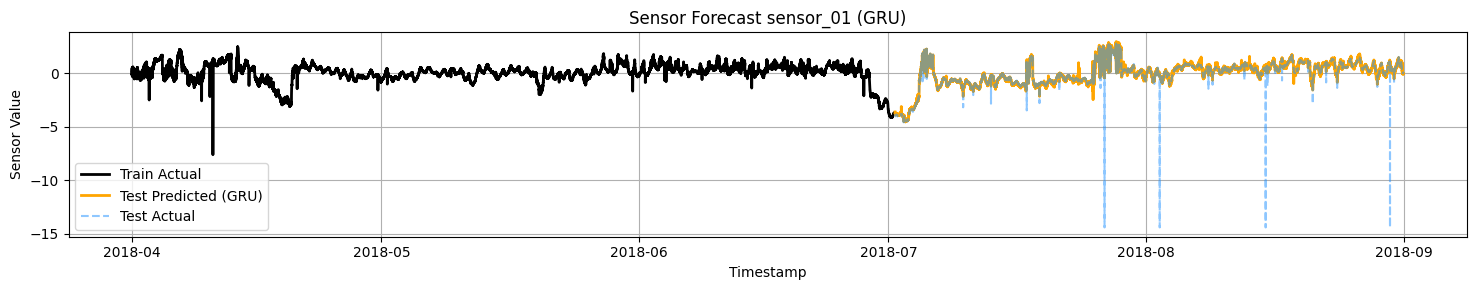

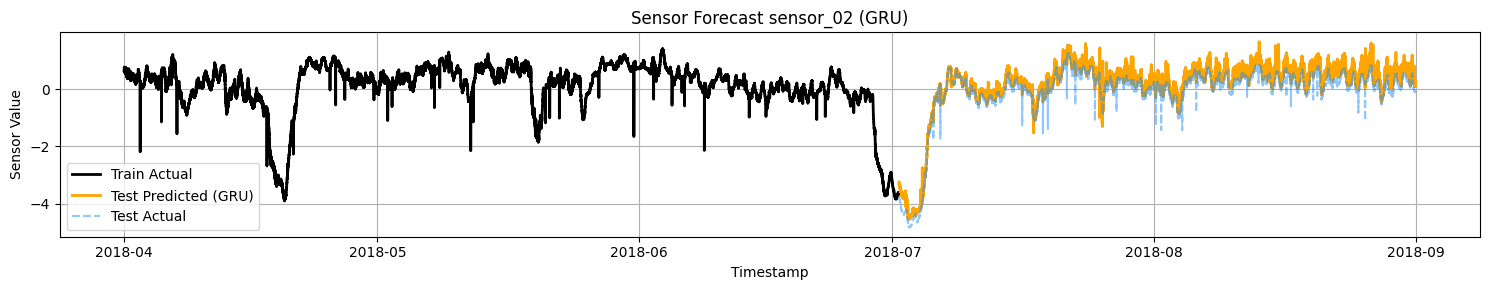

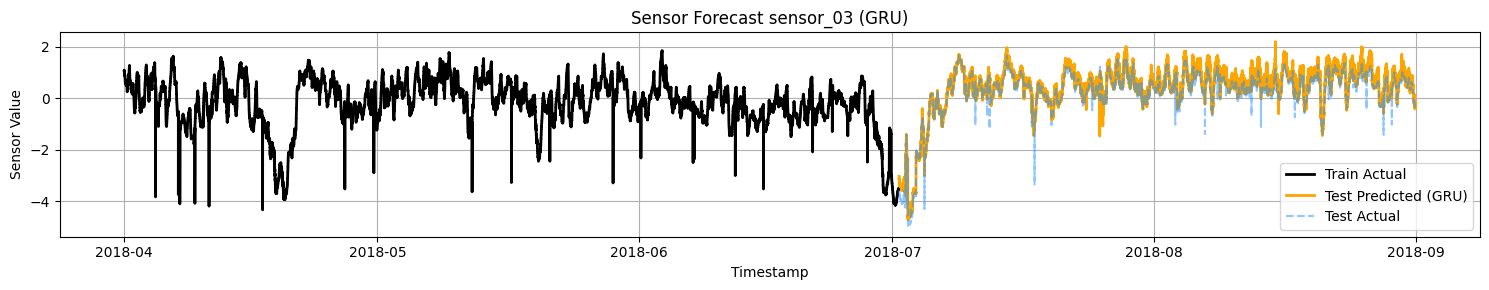

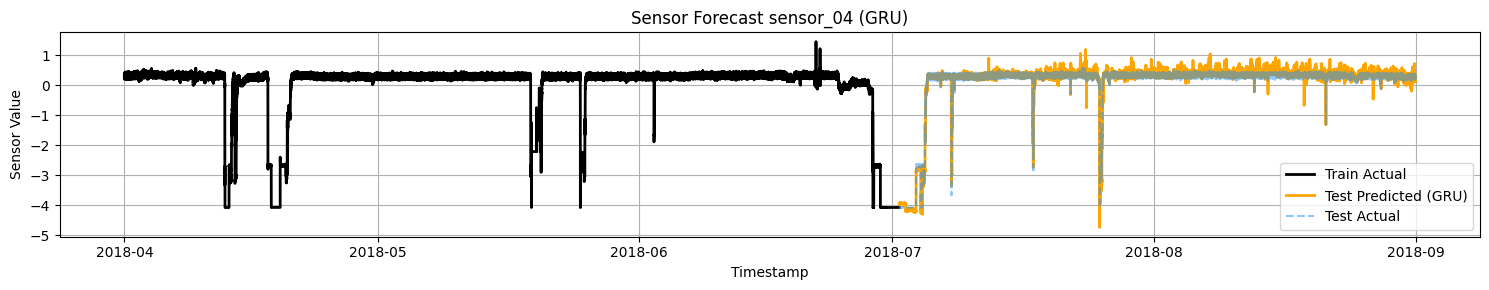

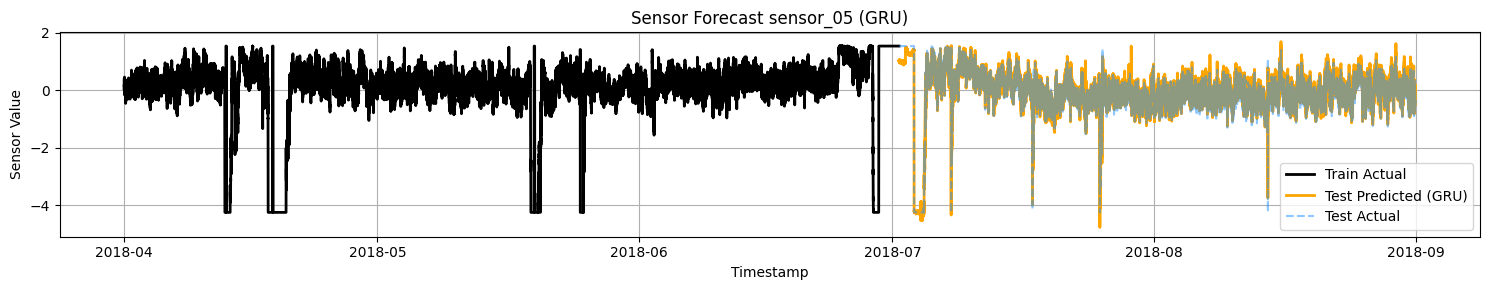

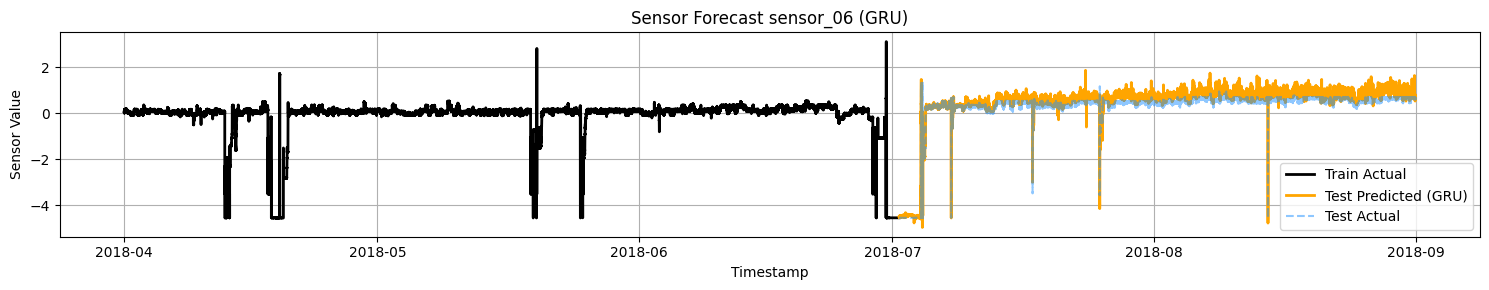

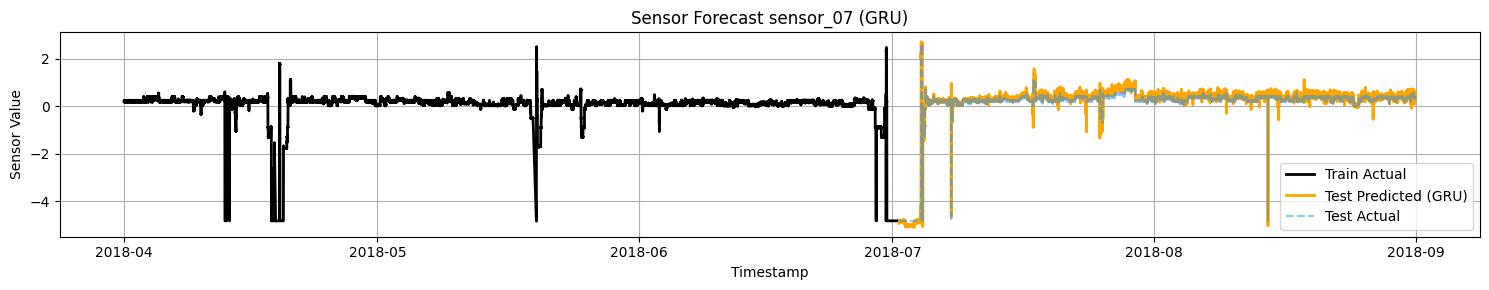

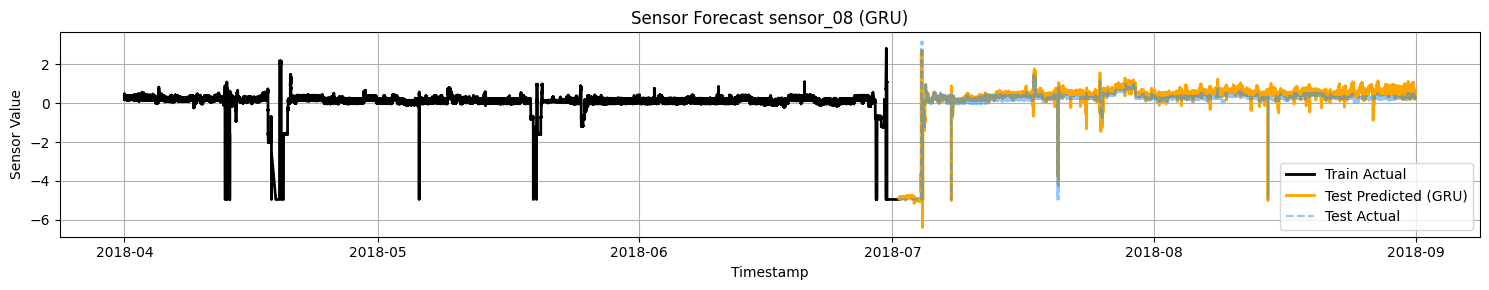

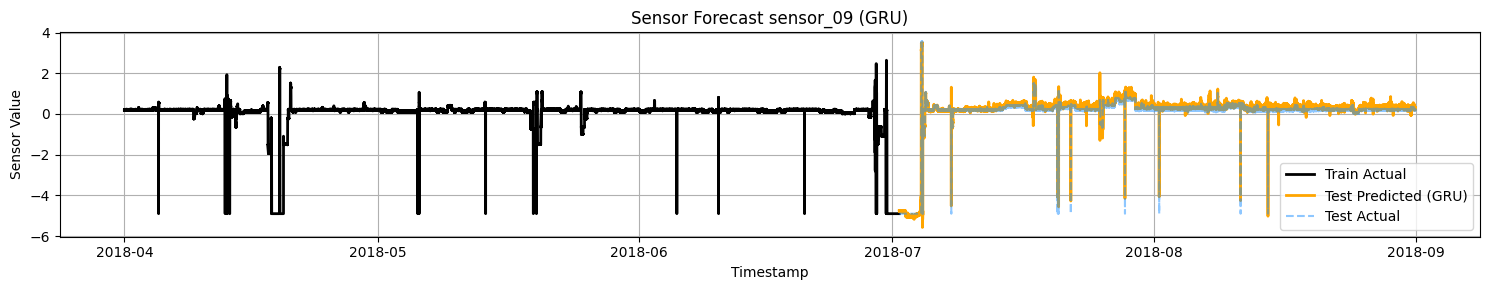

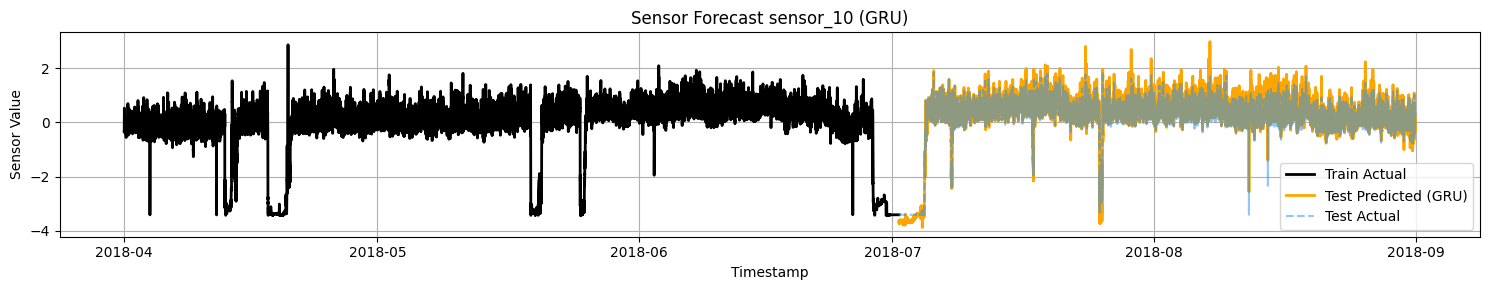

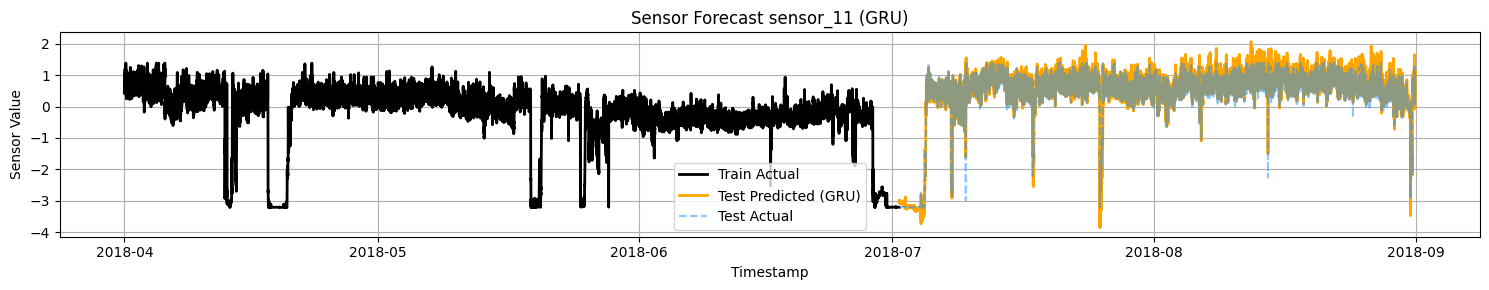

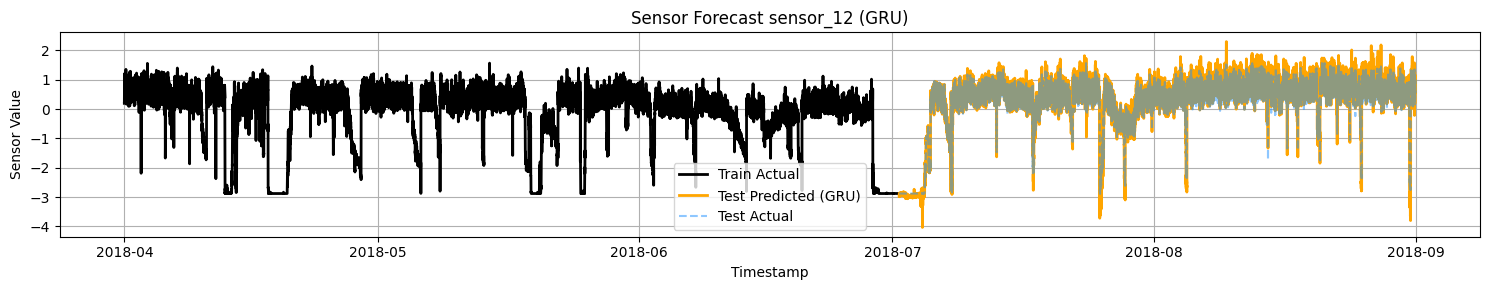

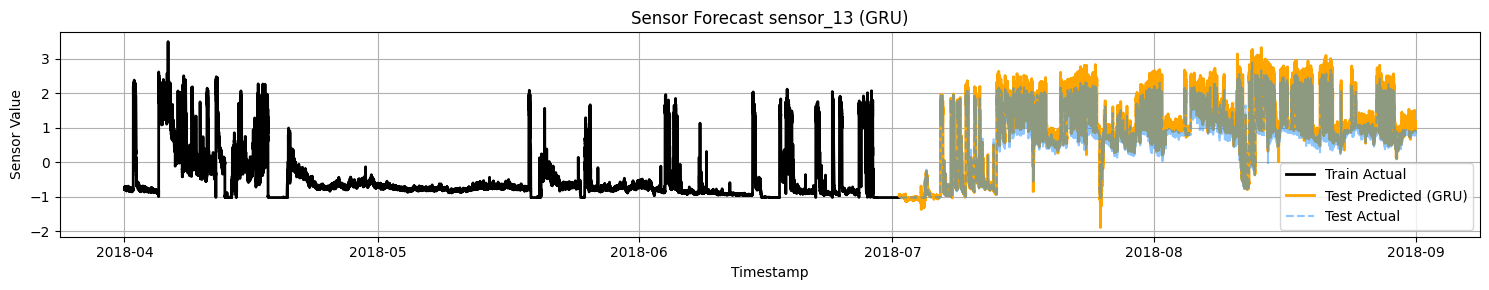

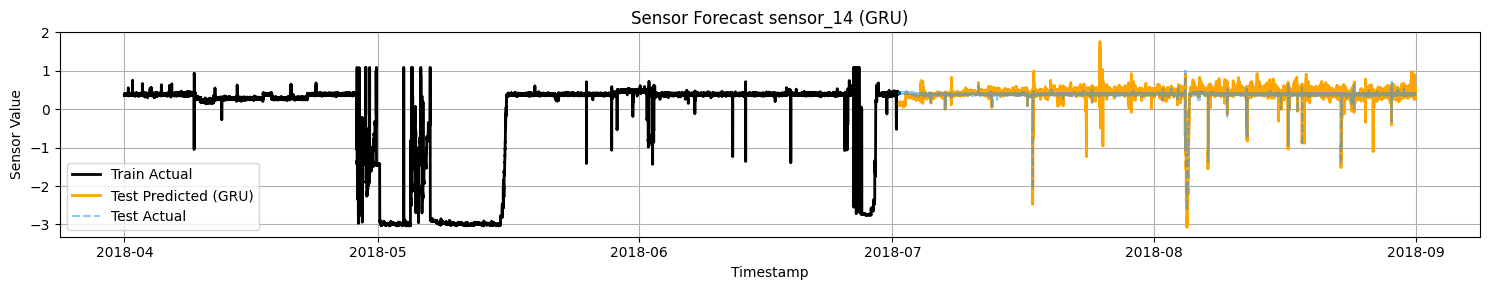

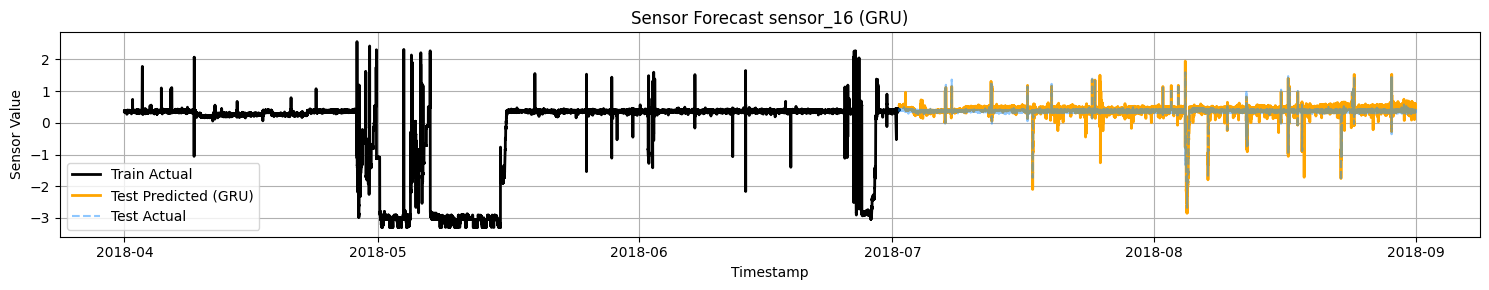

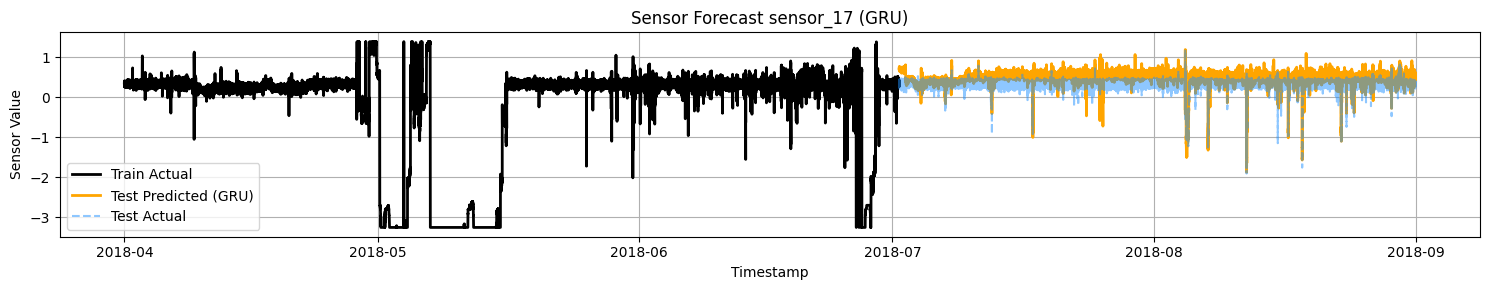

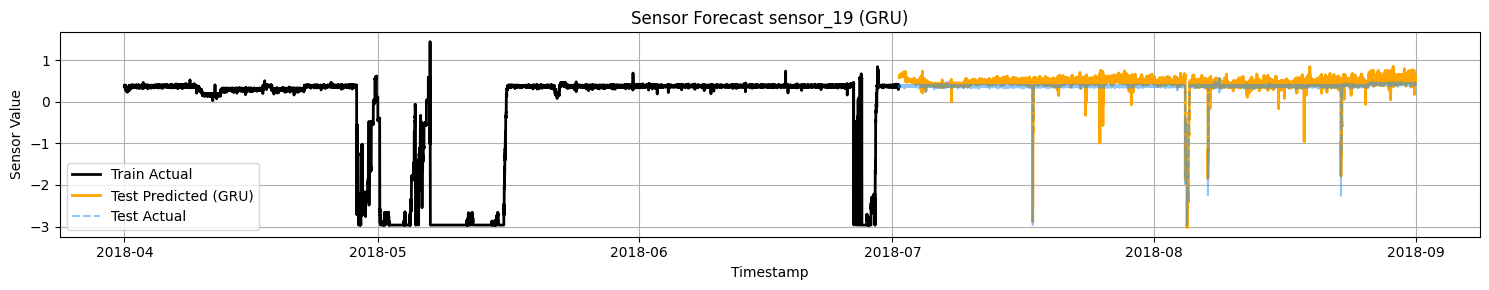

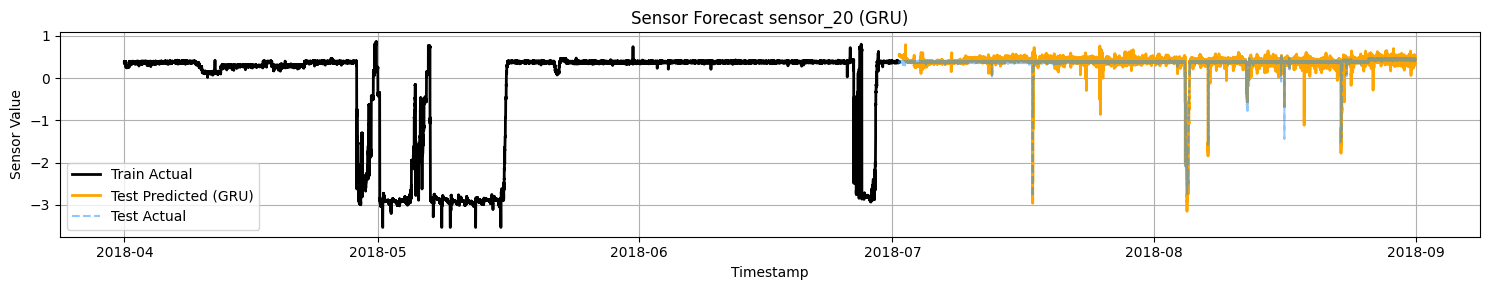

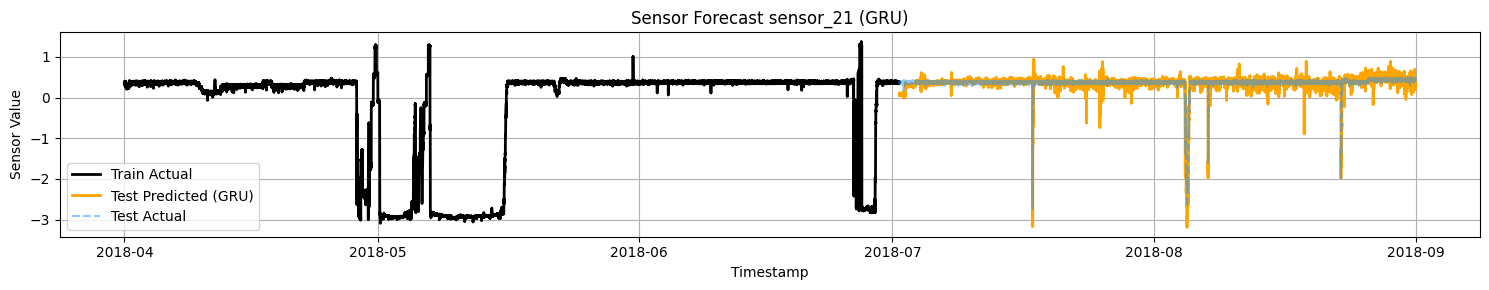

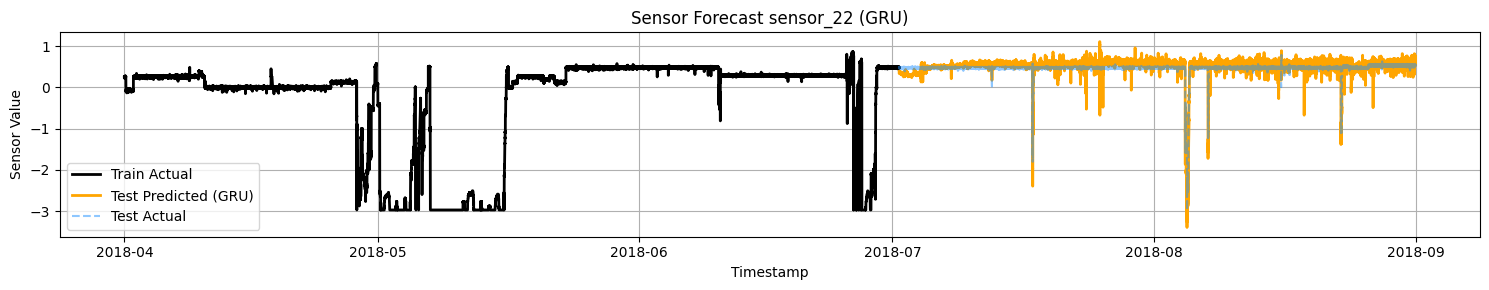

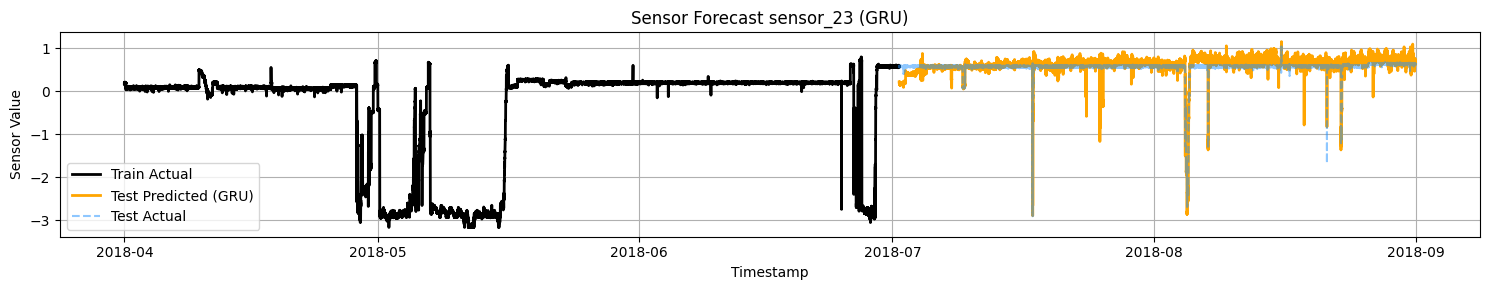

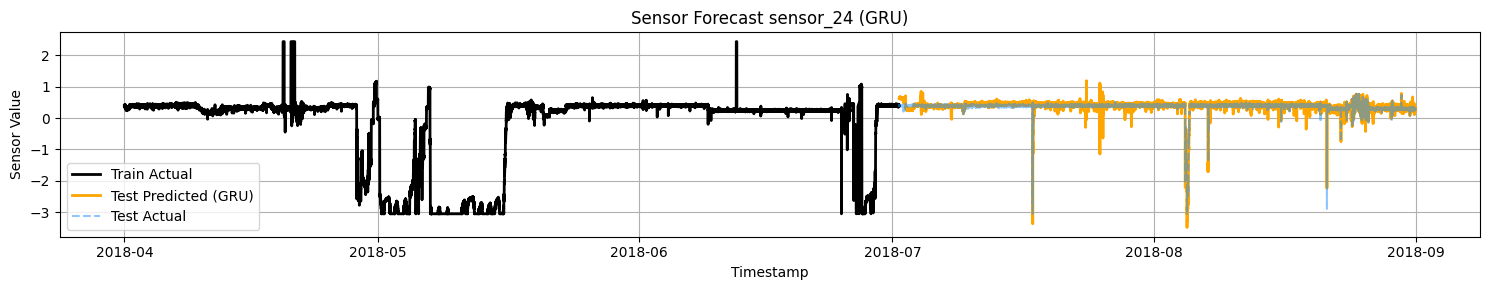

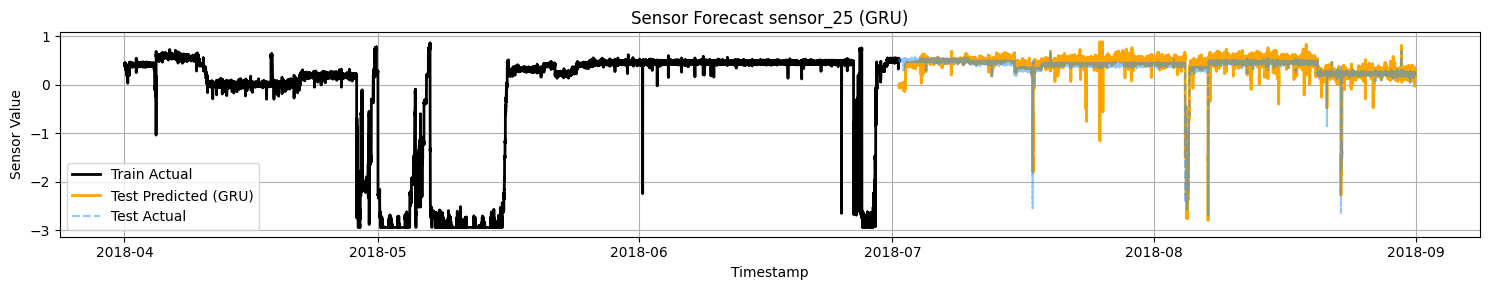

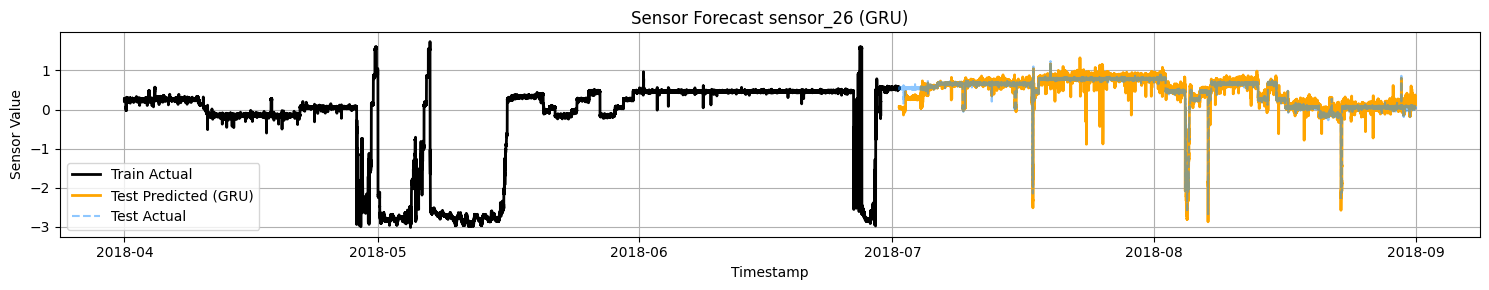

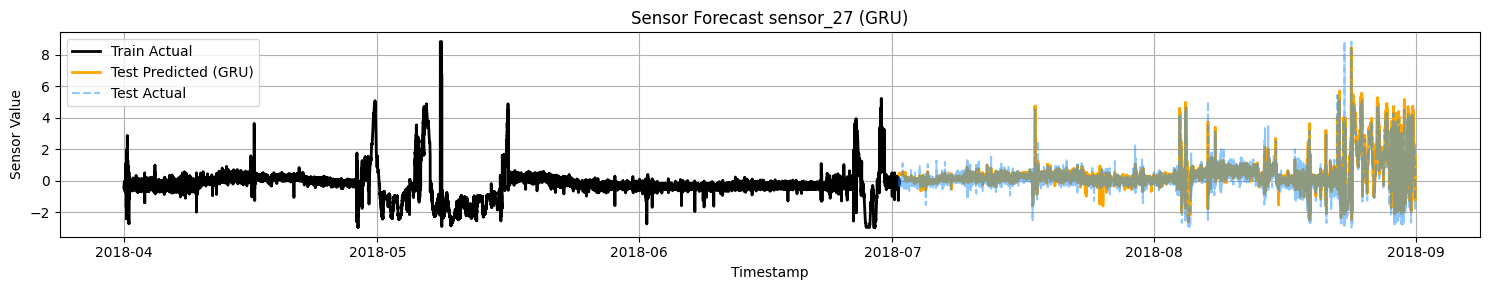

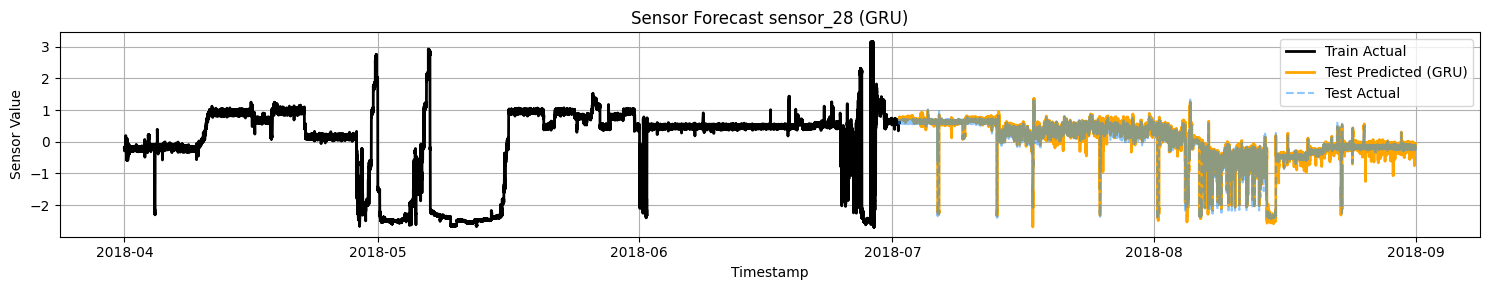

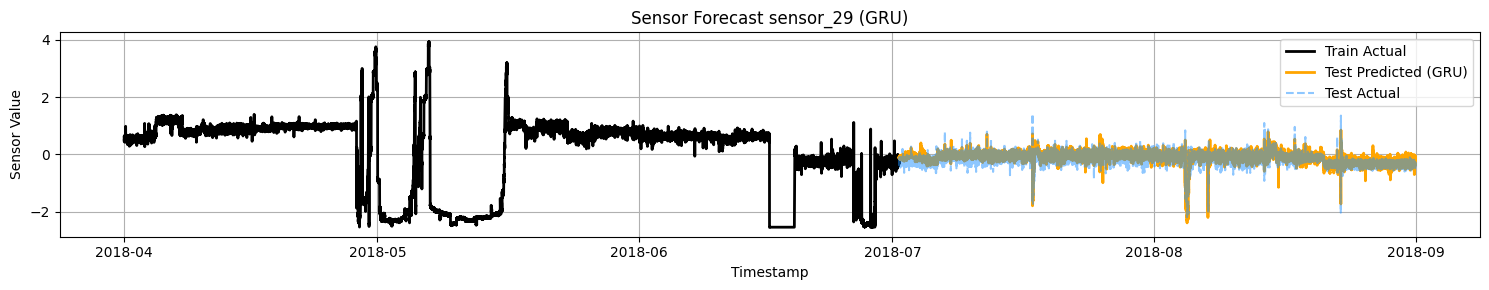

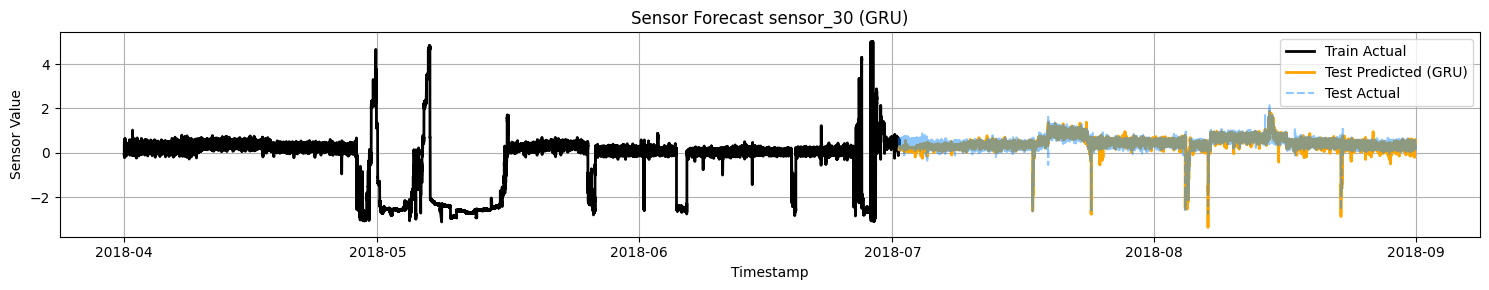

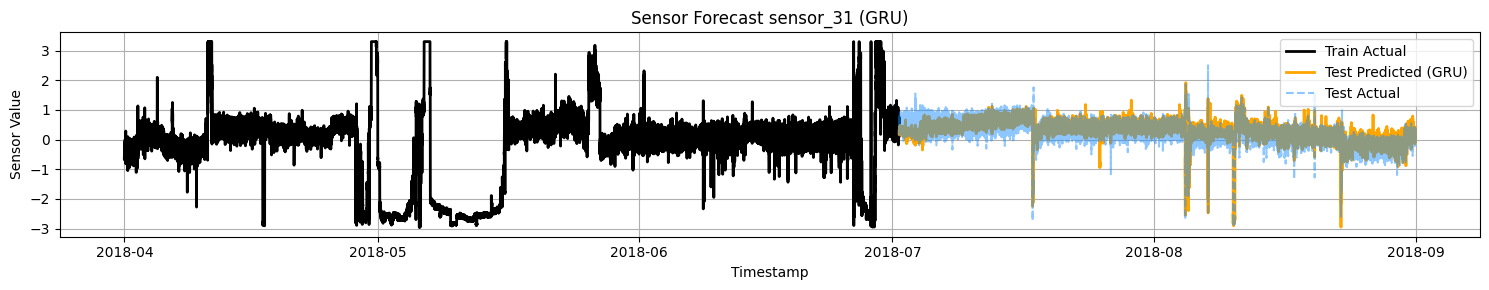

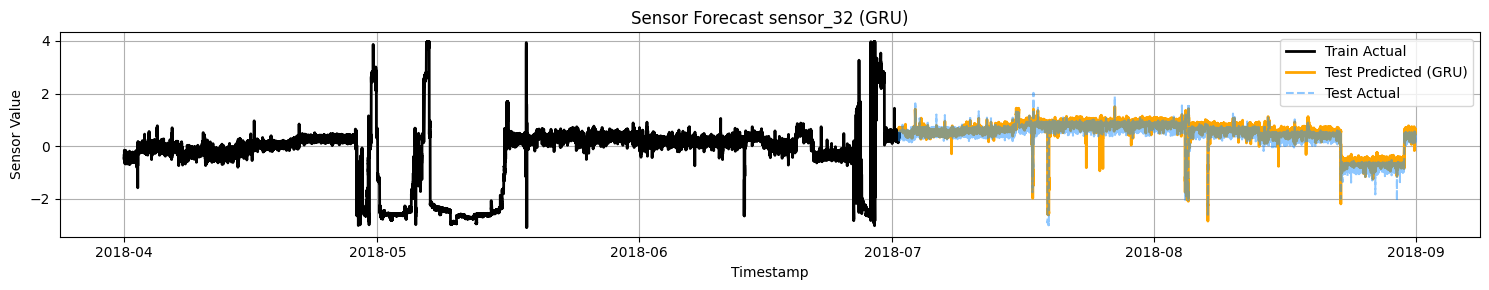

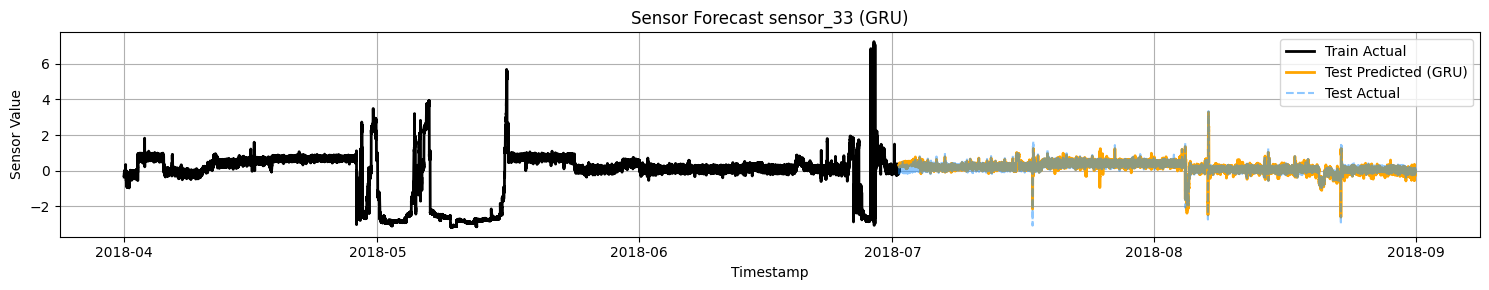

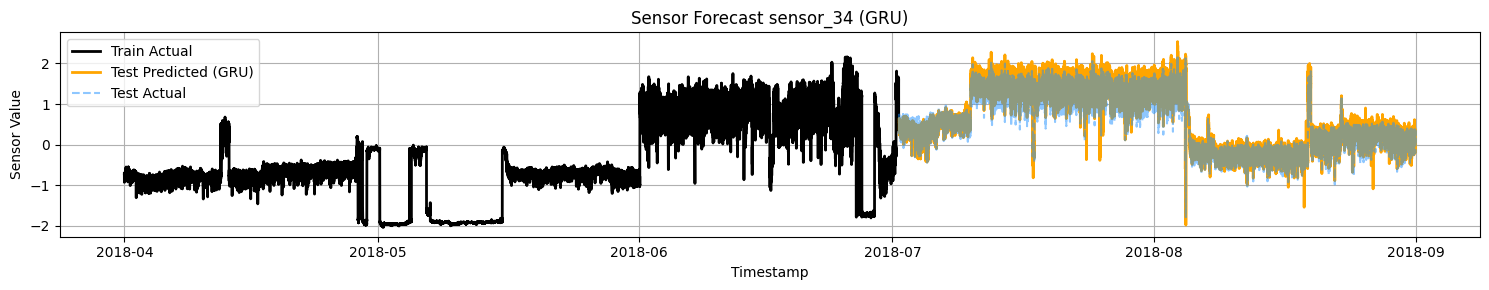

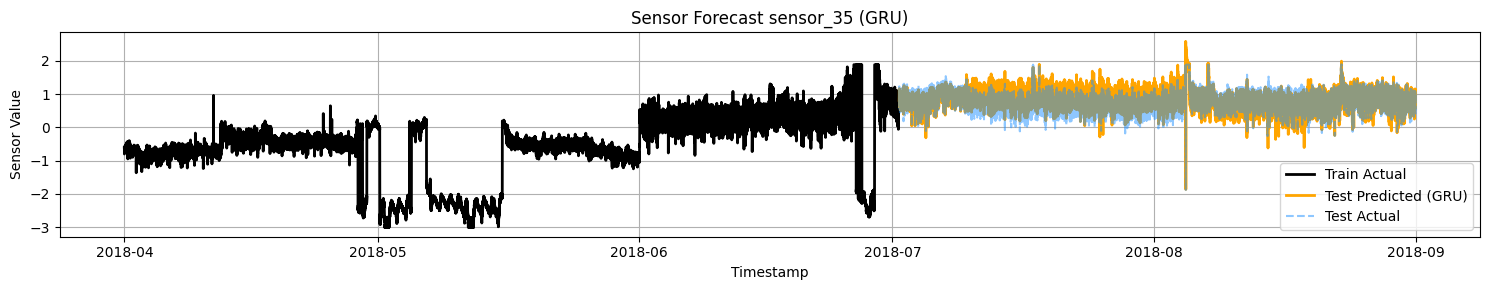

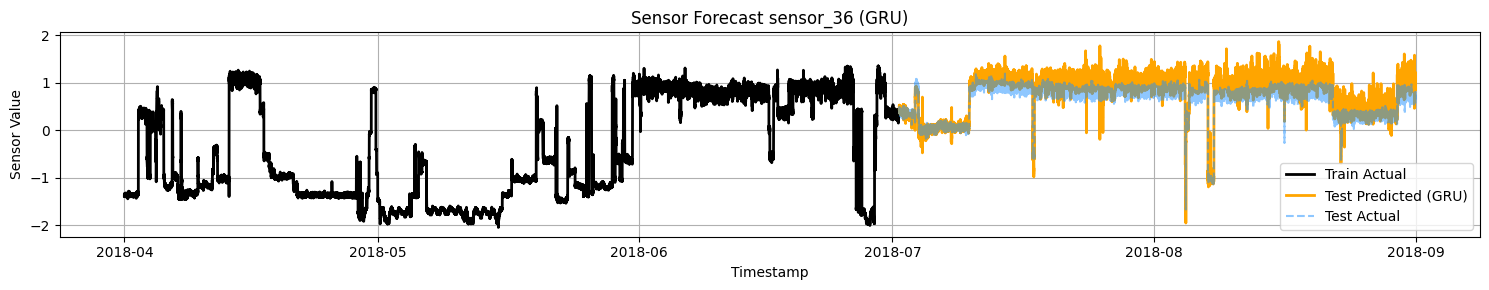

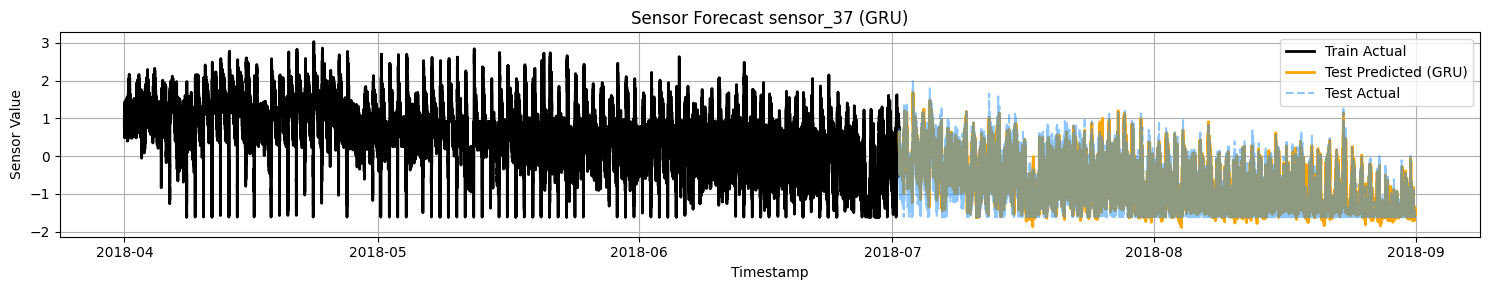

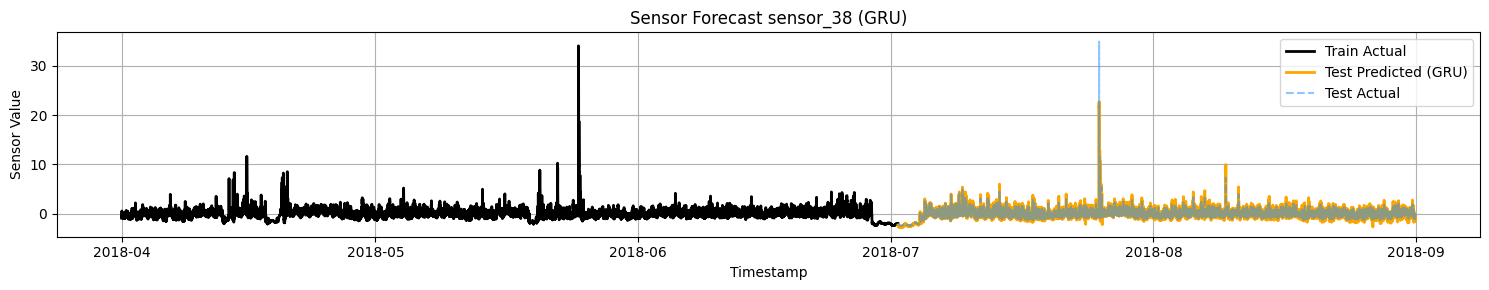

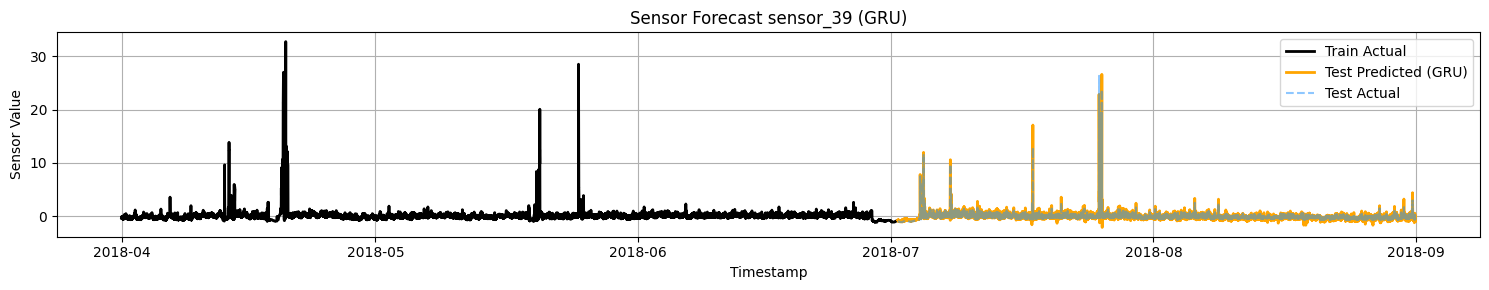

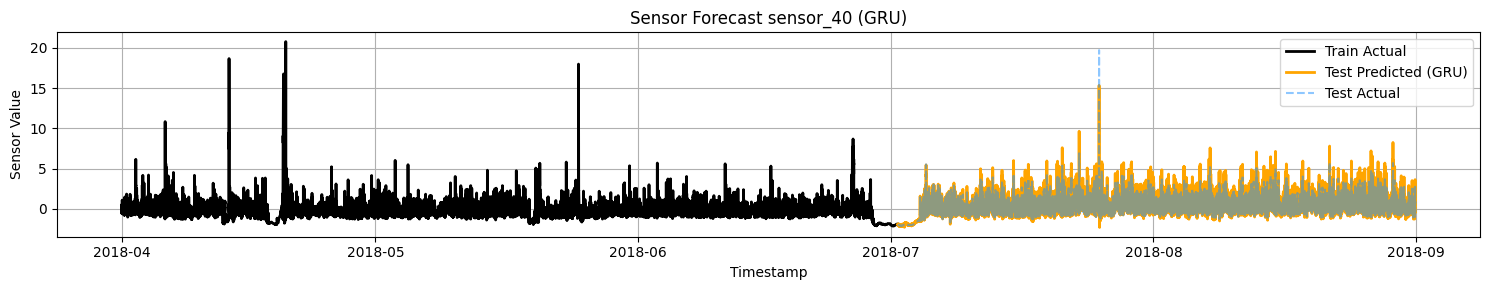

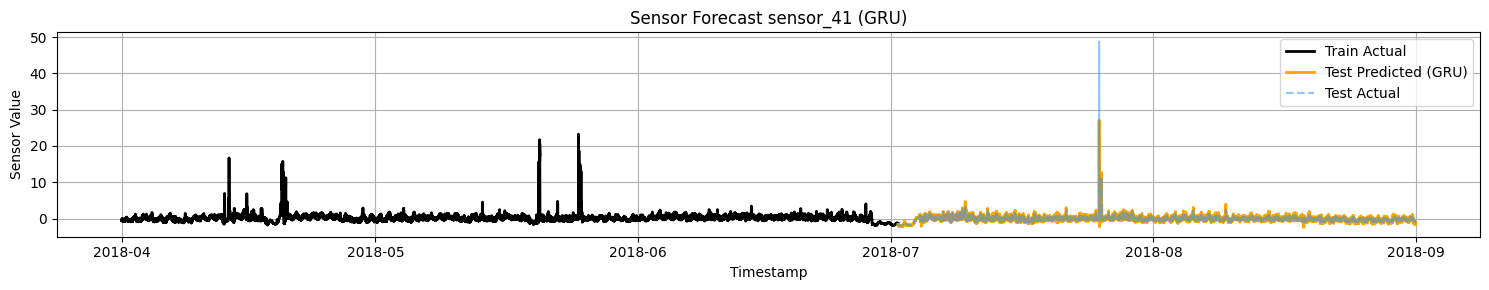

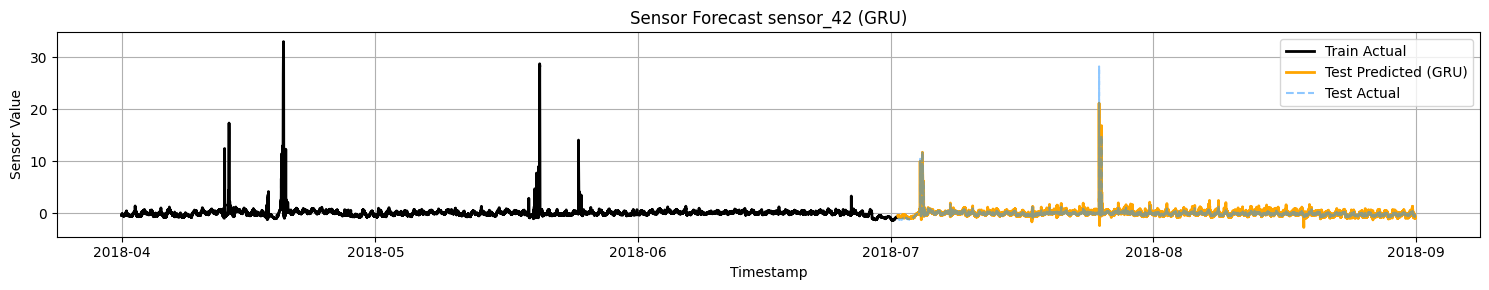

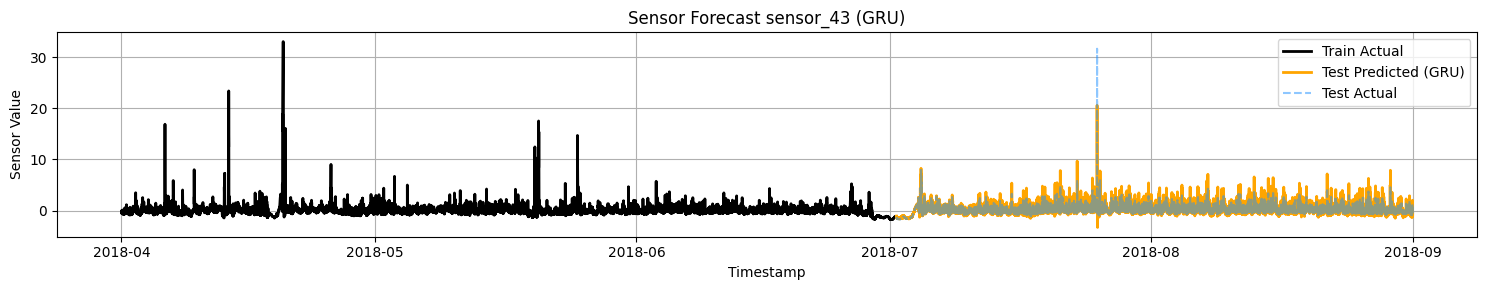

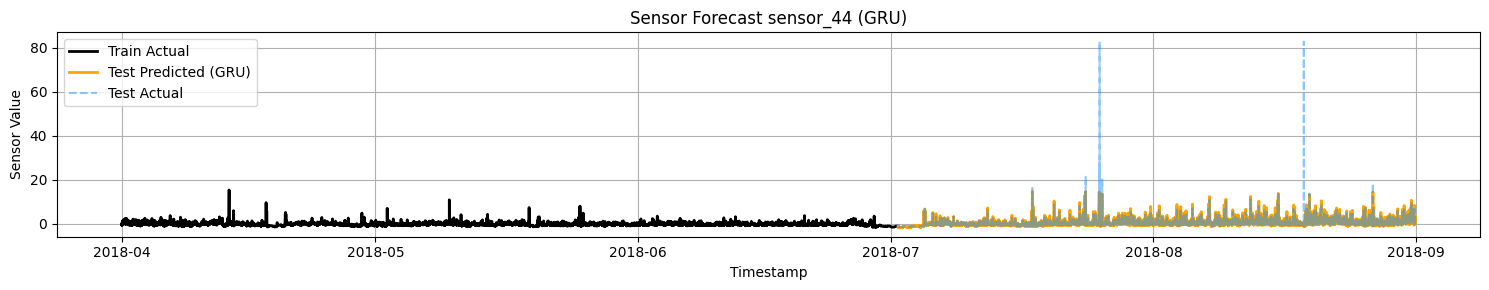

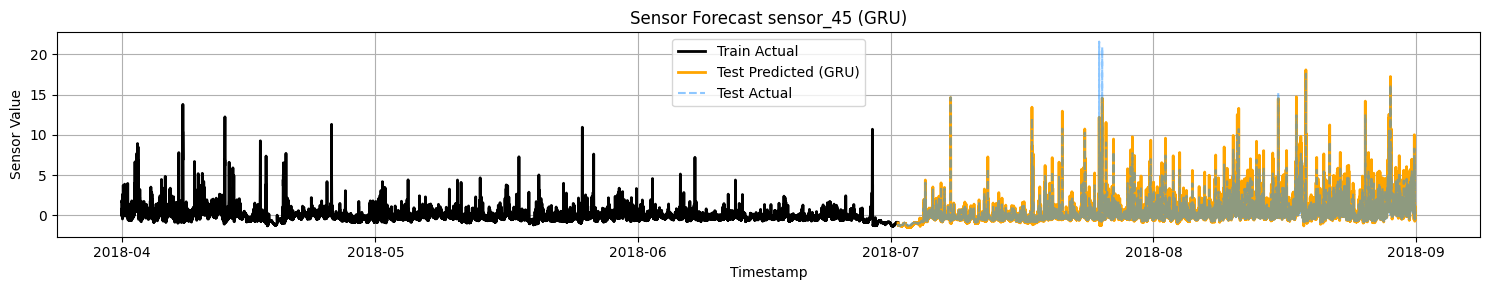

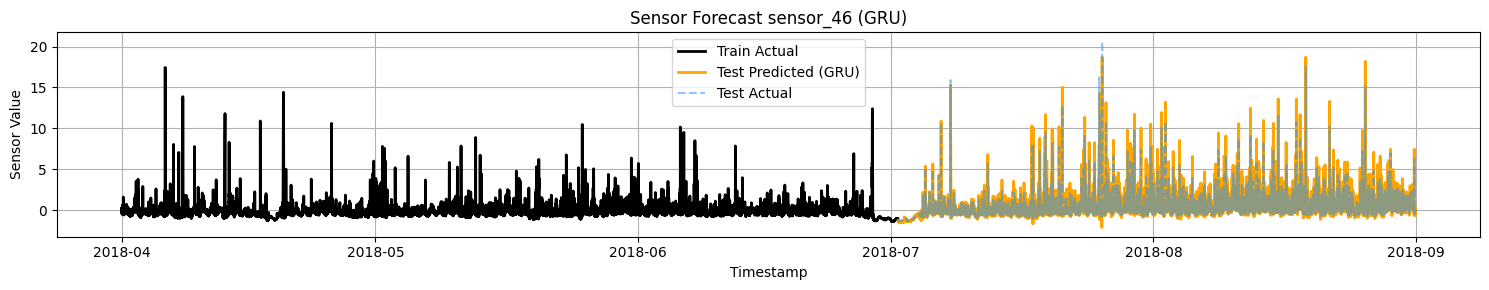

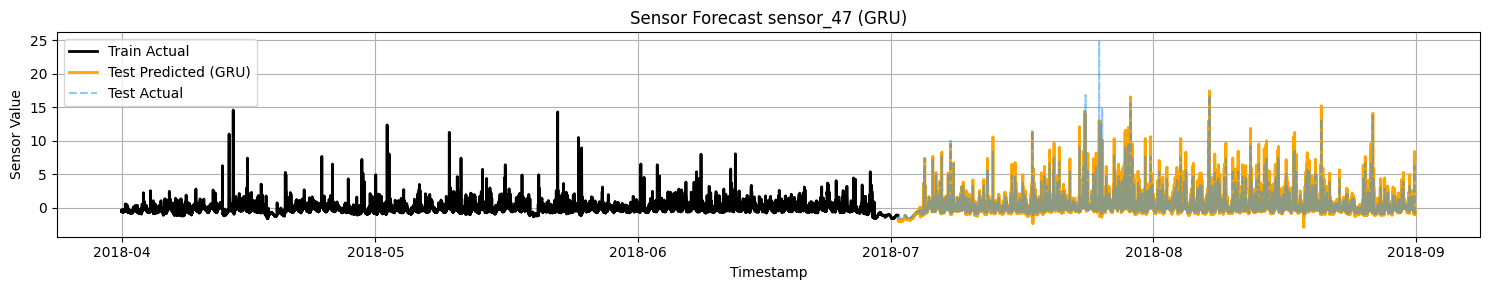

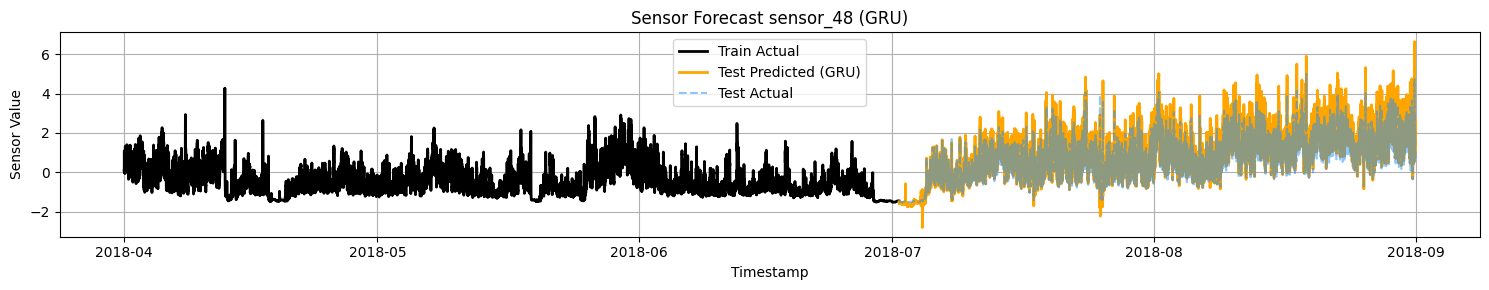

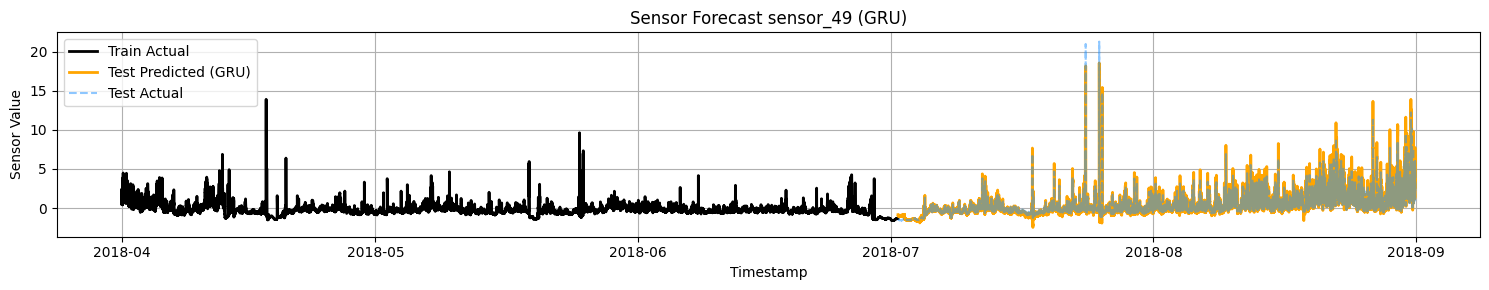

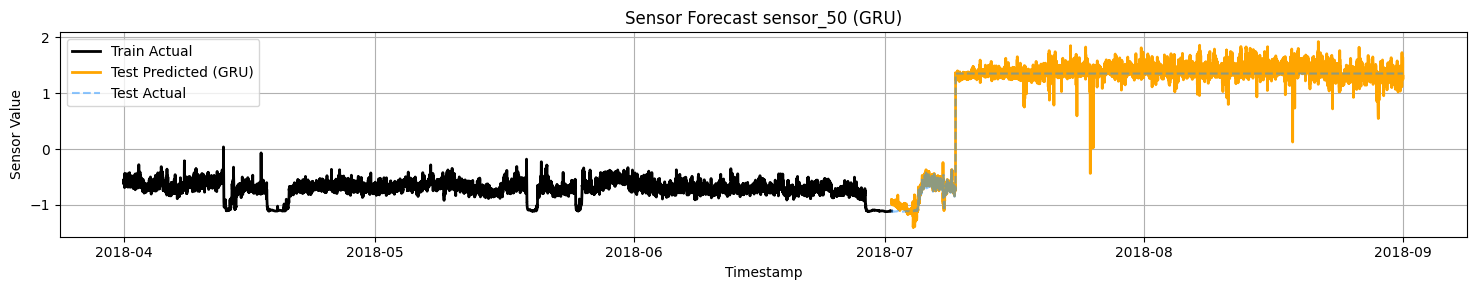

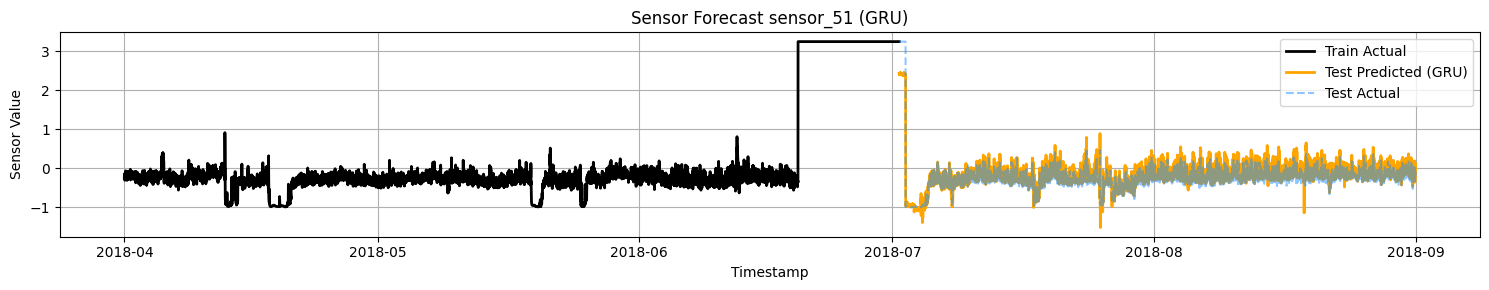

In [109]:
import json
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import load_model

gru_trend_model = load_model("gru_trend_model.h5", compile=False)

gru_X_init = train_data[sensor_cols].values[-60:].reshape(1, 60, len(sensor_cols))
gru_first_y_pred = gru_trend_model.predict(gru_X_init)
gru_y_pred_rest = gru_trend_model.predict(X_test)
gru_y_pred_full = np.vstack([gru_first_y_pred, gru_y_pred_rest])

train_values_orig = scaler.inverse_transform(train_data[sensor_cols].values)
y_pred_orig = scaler.inverse_transform(gru_y_pred_full)
y_test_orig = scaler.inverse_transform(y_test)

time_gap = test_data.index[1] - test_data.index[0]
first_pred_time = train_data.index[-1] + time_gap
pred_timestamps = [first_pred_time + i * time_gap for i in range(len(gru_y_pred_full))]

results = []
for i, sensor in enumerate(sensor_cols):
    result = {
        "sensor": sensor,
        "train_timestamps": train_data.index.astype(str).tolist(),
        "train_values": train_values_orig[:, i].tolist(),
        "test_timestamps": [ts.strftime("%Y-%m-%d %H:%M:%S") for ts in pred_timestamps],
        "predicted_values": y_pred_orig[:, i].tolist(),
        "actual_values": y_test_orig[:, i].tolist()
    }
    results.append(result)

with open("gru_forecast.json", "w", encoding="utf-8") as f:
    json.dump(results, f, indent=2, ensure_ascii=False)

for i, sensor in enumerate(sensor_cols):
    plt.figure(figsize=(15, 3))

    left_y = train_data[sensor].values
    left_t = train_data.index

    right_y = gru_y_pred_full[:, i]
    right_t = pred_timestamps

    actual_right_y = y_test[:, i]

    plt.plot(left_t, left_y, label="Train Actual", color='black', linewidth=2)
    plt.plot(right_t, right_y, label="Test Predicted (GRU)", color='orange', linewidth=2)
    plt.plot(right_t[1:], actual_right_y, label="Test Actual", color='dodgerblue', linestyle='--', alpha=0.5)

    plt.title(f"Sensor Forecast {sensor} (GRU)")
    plt.xlabel("Timestamp")
    plt.ylabel("Sensor Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [110]:
import json
from datetime import datetime, timedelta

with open("recovering_regions.json", "r", encoding="utf-8") as f:
    data = json.load(f)

timestamps_str = data[0]["recovering_timestamps"]
timestamps = sorted([datetime.strptime(ts, "%Y-%m-%d %H:%M:%S") for ts in timestamps_str])

first_timestamps = []
prev_ts = None

for ts in timestamps:
    if prev_ts is None or (ts - prev_ts) > timedelta(minutes=60):
        first_timestamps.append(ts)
    prev_ts = ts

last_train_timestamp = train_data.index[-1]

future_recovery_points = [ts.strftime("%Y-%m-%d %H:%M:%S") for ts in first_timestamps if ts > last_train_timestamp]

print("Train 이후:")
for ts in future_recovery_points:
    print(ts)

print(f"현재 시각: {last_train_timestamp}")

Train 이후:
2018-07-01 20:12:00
2018-07-08 00:14:00
2018-07-25 14:00:00
2018-07-25 18:26:00
현재 시각: 2018-07-01 19:11:00
